In [1]:
# All Imports

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


#import cv2
import sys
import matplotlib.pyplot as plt
import random
#from scipy.misc import imresize

import copy


# GAN model


import matplotlib.pyplot as plt
import sys

#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

In [23]:
# [STAR] PyTorch models for training the regularizer


class RegCNN(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.out_features = 125
        self.in_features  = 125
        
        self.weight = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))
        self.bias   = torch.nn.Parameter(torch.randn(self.out_features, 1))

    def forward(self, x):
        x = torch.matmul(self.weight, x)
        x = self.bias + x
        x = torch.tanh(x)
        x = torch.mean(x, dim=0)
        return(x)

class RegCNNA(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.out_features = 125
        self.in_features  = 125
        
        self.weight1 = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))
        self.bias1   = torch.nn.Parameter(torch.randn(self.out_features, 1))
        
        self.weight2 = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))
        self.bias2   = torch.nn.Parameter(torch.randn(self.out_features, 1))

    def forward(self, x):
        x = torch.matmul(self.weight1, x)
        x = self.bias1 + x
        x = torch.tanh(x)
        
        x = torch.matmul(self.weight2, x)
        x = self.bias2 + x
        x = torch.tanh(x)
        
        x = torch.mean(x, dim=0)
        return(x)
    
# model  = RegCNNA()
# inx    = torch.tensor(np.random.rand(125, 1).astype('float32'))
# print(inx.shape)
# result = model.forward(inx)
# print(result)

torch.Size([125, 1])
tensor([-0.0629], grad_fn=<MeanBackward2>)


In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'
highprojectionpath    = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'
savepath              = '/media/pranjal/newdrive1/DBT-PROJ-DENOISE/'


modelname = "normal-to-three-huber-0.9"

In [4]:
# [STAR] Helper functions for training the de-noising CNN


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg
    
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(imgshape*imgshape) < 0.5:
#                 cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = tempimg[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
#                 j = j+halfvalue
#                 continue
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    #print(np.max(img_adapteq), np.mean(img_adapteq), np.min(img_adapteq), thresh)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    
    #print('restimage max  ', np.max(restimage))
    #print('mul_result max ', np.max(mul_result))
    
    tempvalue = np.min(mul_result)
    #restimage = restimage*np.max(mul_result)
    
    #mul_result   = mul_result + restimage
    #mul_result   = mul_result - tempvalue
    
    #print(mul_result.shape, restimage.shape)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    #print(np.max(mul_result), np.mean(mul_result), np.min(mul_result))
    #print(np.mean(pt2), np.max(pt2), np.min(pt2))
    mul_result   = mul_result.astype(np.uint16)
    #print(np.mean(mul_result), np.max(mul_result), np.min(mul_result))
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 55
    lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [7]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

def huber_loss(y_true, y_pred, clip_delta=0.04):
    error        = y_true - y_pred
    cond         = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=[huber_loss_mean, 'mse'],
            loss_weights=[0.9, 0.1],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)\
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = str(random.randint(43, 68))#+'.dcm'
    
            lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            lowvol  = np.reshape(lowimg,  [25, 1600, 3200])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
            
            for itd in range(discriminator_epochs):
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #print('Training Generator ', epoch)
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            #print('g_loss ', g_loss)
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' D loss real ', -d_loss_real, ' D loss fake ', d_loss_fake, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            # Plot the progress
            #print ("%d [D loss: %f] [G loss: %f] [G loss: %f %f]" % (epoch, 1 - d_loss, 1 - g_loss[0], g_loss[0], g_loss[1]))
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [8]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
# print(aae.generator.summary())
# print(aae.discriminator.summary())

In [ ]:
aae.train(epochs=25000, batch_size=32, sampling=50, saveseed=7590, startepoch=0)

In [ ]:
# [STAR] For denoising the projections of dicom files
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    # Perform sharpening before de-noising
    #lowimg = unsharp_mask(lowimg, radius=3, amount=0.5, preserve_range=True)
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/'
cleanprojpath = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1-750-HUBER/'

#/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights

aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights/generator_weights_750.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)
    
    
#tensorflow.keras.losses.Huber(delta=1.5)
#tf.keras.losses.

In [ ]:
projindex = str(random.randint(43, 68))#+'.dcm'
epoch = 0
batch_size = 32

lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

lowimg  = np.fromfile(lowfilename, dtype='float32')
highimg = np.fromfile(highfilename, dtype='float32')

lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0


slice_index = random.randint(0, 24)
lowimg      = lowvol[slice_index]
highimg     = highvol[slice_index]

# get the cropped image
lowimg, highimg =  get_crop_image(lowimg, highimg)

# Load the dataset
X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
X_train  = X_train  - 0.5
Y_train  = Y_train  - 0.5


print(X_train.shape, Y_train.shape)

In [5]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)




#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = False
normal_dose  = False

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(68, 69):
        print("Phantom ", index)
        a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            #proj_arr = proj_noi#g_noi
        
#         temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
#         temp_proj1 = temp_proj[:, 15:-15, :]
        
#         # Saving the Projections
#         if save_projections:
#             fid = open('/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'.raw', 'w')
#             temp_proj  = np.rollaxis(temp_proj, 0, 2)
#             np.array(temp_proj).astype('float32').tofile(fid)
        

Starting Recon
Phantom  68


In [1]:
import numpy as np
index = 68
all_proj = np.fromfile("/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/3200x1600x25."+str(index)+".raw", dtype='float32')
all_proj = np.reshape(all_proj, [25, 1600, 3200])
                      
print(all_proj.shape)

(25, 1600, 3200)


In [6]:
a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
print(a.shape)        

(800, 448, 320)


In [82]:
# [STAR] Code to read the data

a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/MC_CE27_slice32_atzz666_dense_uppaddle_pc_209923395_crop_1073x2748x816.raw', dtype='uint8')
a = np.reshape(a, [816, 2748, 1073])

print(a.shape)

temp = a[666]

(816, 2748, 1073)


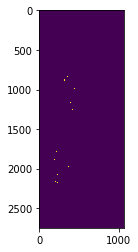

In [83]:
temp[temp != 250] = 0
plt.imshow(temp)

(750, 350)


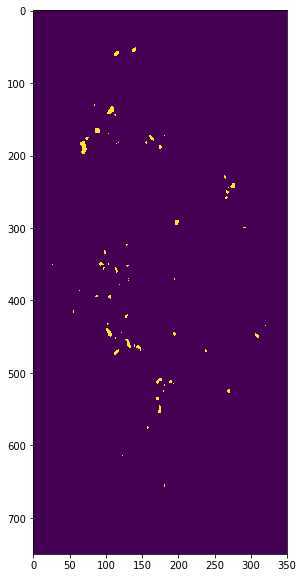

In [84]:
plt.figure(figsize=(20,10))
temp1 = temp[700:1450, 250:600]
print(temp1.shape)
plt.imshow(temp1)

In [77]:
np.save('calcification_cluster.npy', temp1)

(1140, 2415, 1740)


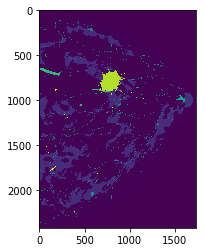

In [3]:
a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop.raw', dtype='uint8')
a = np.reshape(a, [1140, 2415, 1740])
#  1740   2415   1140

print(a.shape)

#temp = a[666]
plt.imshow(a[500])

In [4]:
temp1 = np.load('calcification_cluster.npy')
print(temp1.shape)

(750, 350)


In [89]:
a1    = a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]]
temp1[temp1 != 250] = a1[temp1 != 250]

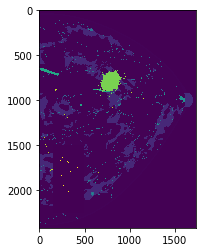

In [6]:
#a[499, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[501, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1

plt.imshow(a[501])

In [7]:
a.tofile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop_calci.raw')

In [641]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1
#plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
print(a.shape, b.shape, e.shape)

(858161,) (858161,)
(58, 1200, 3000) (58, 1200, 3000) (58, 1200, 3000)


(858161,) (858161,)
85793 85793 858161
(85793, 125) (85793,)


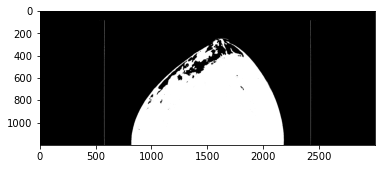

In [12]:
# [STAR] For creating the dataset to train the potential function

e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_0_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

#b = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_normal_1.raw', dtype='float32')
#b = np.reshape(b, [58, 1200, 3000])

#c = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_three_1.raw', dtype='float32')
#c = np.reshape(c, [58, 1200, 3000])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

#temp1 = a[:, 900:1150, 950:1350]
#D2    = d[:, 900:1150, 950:1350]

Y_array = d
X_array = a


# For getting the locations of the training data points

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1

#temp[temp < 0.045] = 0
plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
#print(a.shape, b.shape, e.shape)


# Generate the samples for the Regression Model

X      = []
Y      = []
voxels = 5


for i in range(non_zero_index[0].shape[0]):
    if np.random.rand() > 0.1:
        continue
    
    ind_z = random.randint(15, 45)
    ind_y = non_zero_index[0][i]
    ind_x = non_zero_index[1][i]
    
    tx = X_array[ind_z-2:ind_z+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
    ty = Y_array[ind_z,           non_zero_index[0][i], non_zero_index[1][i]]
    
    if len(tx.flatten()) ==  voxels*voxels*voxels:
        X.append(tx - X_array[ind_z, non_zero_index[0][i], non_zero_index[1][i]])
        Y.append(ty)

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)
#Y =  np.reshape(Y, [Y.shape[0], 1])

print(X.shape, Y.shape)

In [ ]:
# Duplicate Code

X = []
Y = []
voxels = 5


for i in range(non_zero_index[0].shape[0]):
    ind_z = 27
    ind_y = non_zero_index[0][i]
    ind_x = non_zero_index[1][i]
    
    if ind_y+2 < X_array.shape[1] and ind_x+2 < X_array.shape[2] and ind_y-2 >= 0 and ind_x-2 >= 0:
        #tx  = []
        #for ind_nr_z  in range(ind_z-2, ind_z+3):
        #    for ind_nr_y in range(ind_y-2, ind_y+3):
        #        for ind_nr_x in range(ind_x-2, ind_x+3):
        #            tx.append(X_array[ind_nr_z][ind_nr_y][ind_nr_x])

        tx = X_array[27-2:27+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
        ty = Y_array[27, non_zero_index[0][i], non_zero_index[1][i]]
        
        if len(tx.flatten()) ==  voxels*voxels*voxels:
            X.append(tx)
            Y.append(ty)
        
        tx = X_array[40-2:40+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
        ty = Y_array[40, non_zero_index[0][i], non_zero_index[1][i]]
        
        if len(tx.flatten()) ==  voxels*voxels*voxels:
            X.append(tx)
            Y.append(ty)

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)
#Y =  np.reshape(Y, [Y.shape[0], 1])

print(X.shape, Y.shape)

In [21]:
# For training the Regression Model using PyTorch

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

device         = torch.device("cuda:0")

model  = RegCNN()
model.cuda()

criterion          = nn.L1Loss(reduce=False, )#.MSELoss()
optimizer_student  = optim.Adam(model.parameters(), lr=0.001)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :].T
        y = valy[ik*batch_size:(ik+1)*batch_size]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = output.data.cpu().numpy()
        
        dt = np.abs(y - output)
        dt = np.mean(dt)
        
        val_dice.append(dt)
    return val_dice


def train_model(model, batch_size, optimizer, criterion, trainx, trainy):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :].T
        y = trainy[i*batch_size:(i+1)*batch_size]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss   = criterion(output , y)
        #print(i, output.shape, loss.shape, y.shape)
        loss   = torch.mean(loss)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array


X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


for i in range(50000):
    train_model(model, 10, optimizer_student, criterion, X_train, y_train)
    result = evaluate_result(model, X_test, y_test)
    
    print(i, 'Validation Accuracy ', np.mean(result))

(64344, 125) (21449, 125) (64344,) (21449,)
0 Validation Accuracy  0.007043158
1 Validation Accuracy  0.006990833
2 Validation Accuracy  0.0069250474
3 Validation Accuracy  0.0069422205
4 Validation Accuracy  0.006907346
5 Validation Accuracy  0.0069025983
6 Validation Accuracy  0.006905653
7 Validation Accuracy  0.0068982034
8 Validation Accuracy  0.0068969144
9 Validation Accuracy  0.0069962796
10 Validation Accuracy  0.00691244
11 Validation Accuracy  0.0069272486
12 Validation Accuracy  0.006911862
13 Validation Accuracy  0.0069368538
14 Validation Accuracy  0.00690912
15 Validation Accuracy  0.006915858
16 Validation Accuracy  0.006895708
17 Validation Accuracy  0.006940422
18 Validation Accuracy  0.006902369
19 Validation Accuracy  0.006932295
20 Validation Accuracy  0.006919428
21 Validation Accuracy  0.0069030453
22 Validation Accuracy  0.006877432
23 Validation Accuracy  0.0069093583
24 Validation Accuracy  0.006910256
25 Validation Accuracy  0.0068730456
26 Validation Accurac

221 Validation Accuracy  0.0060151042
222 Validation Accuracy  0.0060320967
223 Validation Accuracy  0.0060267
224 Validation Accuracy  0.0060170596
225 Validation Accuracy  0.0060101147
226 Validation Accuracy  0.0060111475
227 Validation Accuracy  0.0060130013
228 Validation Accuracy  0.0060080187
229 Validation Accuracy  0.0060080835
230 Validation Accuracy  0.006016212
231 Validation Accuracy  0.006014489
232 Validation Accuracy  0.00600266
233 Validation Accuracy  0.0060057216
234 Validation Accuracy  0.0059935837
235 Validation Accuracy  0.0060028927
236 Validation Accuracy  0.0059956987
237 Validation Accuracy  0.005991794
238 Validation Accuracy  0.0059931604
239 Validation Accuracy  0.0059893923
240 Validation Accuracy  0.005990998
241 Validation Accuracy  0.005995078
242 Validation Accuracy  0.00598465
243 Validation Accuracy  0.0059862053
244 Validation Accuracy  0.0059830295
245 Validation Accuracy  0.0059865233
246 Validation Accuracy  0.0059821196
247 Validation Accuracy 

440 Validation Accuracy  0.0057900967
441 Validation Accuracy  0.0057834825
442 Validation Accuracy  0.0057841213
443 Validation Accuracy  0.005785397
444 Validation Accuracy  0.0057866815
445 Validation Accuracy  0.0057813106
446 Validation Accuracy  0.0057839616
447 Validation Accuracy  0.005781849
448 Validation Accuracy  0.0057795816
449 Validation Accuracy  0.005778498
450 Validation Accuracy  0.0057788463
451 Validation Accuracy  0.0057786778
452 Validation Accuracy  0.005782238
453 Validation Accuracy  0.005778608
454 Validation Accuracy  0.005779736
455 Validation Accuracy  0.0057778927
456 Validation Accuracy  0.005775733
457 Validation Accuracy  0.0057792002
458 Validation Accuracy  0.005775365
459 Validation Accuracy  0.0057737655
460 Validation Accuracy  0.0057726745
461 Validation Accuracy  0.0057752165
462 Validation Accuracy  0.0057713855
463 Validation Accuracy  0.0057748975
464 Validation Accuracy  0.0057690907
465 Validation Accuracy  0.0057681506
466 Validation Accur

659 Validation Accuracy  0.0056749117
660 Validation Accuracy  0.00567473
661 Validation Accuracy  0.005669792
662 Validation Accuracy  0.0056710416
663 Validation Accuracy  0.0056737377
664 Validation Accuracy  0.005669431
665 Validation Accuracy  0.0056684376
666 Validation Accuracy  0.0056687933
667 Validation Accuracy  0.005670057
668 Validation Accuracy  0.005669877
669 Validation Accuracy  0.005670882
670 Validation Accuracy  0.005671127
671 Validation Accuracy  0.005668019
672 Validation Accuracy  0.00567052
673 Validation Accuracy  0.0056664627
674 Validation Accuracy  0.00566642
675 Validation Accuracy  0.0056654904
676 Validation Accuracy  0.0056650797
677 Validation Accuracy  0.005666108
678 Validation Accuracy  0.0056647244
679 Validation Accuracy  0.005667464
680 Validation Accuracy  0.005667642
681 Validation Accuracy  0.005665602
682 Validation Accuracy  0.0056636175
683 Validation Accuracy  0.005666823
684 Validation Accuracy  0.005663065
685 Validation Accuracy  0.0056

879 Validation Accuracy  0.005608411
880 Validation Accuracy  0.005611057
881 Validation Accuracy  0.0056117605
882 Validation Accuracy  0.0056098043
883 Validation Accuracy  0.005608386
884 Validation Accuracy  0.0056059505
885 Validation Accuracy  0.005607366
886 Validation Accuracy  0.0056080488
887 Validation Accuracy  0.005608504
888 Validation Accuracy  0.005610076
889 Validation Accuracy  0.0056058723
890 Validation Accuracy  0.0056088762
891 Validation Accuracy  0.0056076027
892 Validation Accuracy  0.005606327
893 Validation Accuracy  0.005604694
894 Validation Accuracy  0.0056053484
895 Validation Accuracy  0.0056040576
896 Validation Accuracy  0.0056075
897 Validation Accuracy  0.005604551
898 Validation Accuracy  0.0056043207
899 Validation Accuracy  0.0056040366
900 Validation Accuracy  0.0056045735
901 Validation Accuracy  0.0056034555
902 Validation Accuracy  0.0056040976
903 Validation Accuracy  0.0056027006
904 Validation Accuracy  0.0056034573
905 Validation Accuracy 

1095 Validation Accuracy  0.0055711125
1096 Validation Accuracy  0.005570523
1097 Validation Accuracy  0.00557178
1098 Validation Accuracy  0.005570195
1099 Validation Accuracy  0.0055688233
1100 Validation Accuracy  0.005572178
1101 Validation Accuracy  0.0055711796
1102 Validation Accuracy  0.0055692997
1103 Validation Accuracy  0.00557088
1104 Validation Accuracy  0.0055704652
1105 Validation Accuracy  0.0055690906
1106 Validation Accuracy  0.005569519
1107 Validation Accuracy  0.0055702482
1108 Validation Accuracy  0.005568445
1109 Validation Accuracy  0.005568509
1110 Validation Accuracy  0.0055680624
1111 Validation Accuracy  0.005570932
1112 Validation Accuracy  0.0055694766
1113 Validation Accuracy  0.0055702776
1114 Validation Accuracy  0.005569335
1115 Validation Accuracy  0.0055702114
1116 Validation Accuracy  0.0055693346
1117 Validation Accuracy  0.0055674505
1118 Validation Accuracy  0.0055682356
1119 Validation Accuracy  0.005567325
1120 Validation Accuracy  0.005568258


1308 Validation Accuracy  0.0055410345
1309 Validation Accuracy  0.005540872
1310 Validation Accuracy  0.00554379
1311 Validation Accuracy  0.005541446
1312 Validation Accuracy  0.005538986
1313 Validation Accuracy  0.0055412846
1314 Validation Accuracy  0.00554115
1315 Validation Accuracy  0.005542591
1316 Validation Accuracy  0.005538792
1317 Validation Accuracy  0.0055410923
1318 Validation Accuracy  0.0055390727
1319 Validation Accuracy  0.0055404273
1320 Validation Accuracy  0.0055407155
1321 Validation Accuracy  0.0055372445
1322 Validation Accuracy  0.00553956
1323 Validation Accuracy  0.005539539
1324 Validation Accuracy  0.0055389362
1325 Validation Accuracy  0.005537606
1326 Validation Accuracy  0.005539616
1327 Validation Accuracy  0.00553606
1328 Validation Accuracy  0.0055383644
1329 Validation Accuracy  0.0055372524
1330 Validation Accuracy  0.0055398783
1331 Validation Accuracy  0.0055403016
1332 Validation Accuracy  0.0055389497
1333 Validation Accuracy  0.005538893
133

1522 Validation Accuracy  0.0055052736
1523 Validation Accuracy  0.0055074003
1524 Validation Accuracy  0.005507201
1525 Validation Accuracy  0.0055071223
1526 Validation Accuracy  0.005505809
1527 Validation Accuracy  0.005506048
1528 Validation Accuracy  0.0055059935
1529 Validation Accuracy  0.0055049653
1530 Validation Accuracy  0.0055048657
1531 Validation Accuracy  0.005505928
1532 Validation Accuracy  0.005505102
1533 Validation Accuracy  0.0055030896
1534 Validation Accuracy  0.0055051567
1535 Validation Accuracy  0.005506315
1536 Validation Accuracy  0.0055063954
1537 Validation Accuracy  0.0055041215
1538 Validation Accuracy  0.005504592
1539 Validation Accuracy  0.005503246
1540 Validation Accuracy  0.0055029104
1541 Validation Accuracy  0.005505623
1542 Validation Accuracy  0.0055056713
1543 Validation Accuracy  0.0055064033
1544 Validation Accuracy  0.0055058273
1545 Validation Accuracy  0.0055024754
1546 Validation Accuracy  0.005501879
1547 Validation Accuracy  0.0055032

1735 Validation Accuracy  0.0054753274
1736 Validation Accuracy  0.0054751267
1737 Validation Accuracy  0.005475546
1738 Validation Accuracy  0.005474397
1739 Validation Accuracy  0.005474591
1740 Validation Accuracy  0.0054763746
1741 Validation Accuracy  0.00547561
1742 Validation Accuracy  0.0054763444
1743 Validation Accuracy  0.005474809
1744 Validation Accuracy  0.0054758787
1745 Validation Accuracy  0.005475689
1746 Validation Accuracy  0.005475143
1747 Validation Accuracy  0.0054748277
1748 Validation Accuracy  0.0054758186
1749 Validation Accuracy  0.005475417
1750 Validation Accuracy  0.0054758126
1751 Validation Accuracy  0.0054732584
1752 Validation Accuracy  0.0054745646
1753 Validation Accuracy  0.005472606
1754 Validation Accuracy  0.0054735686
1755 Validation Accuracy  0.0054715723
1756 Validation Accuracy  0.005473737
1757 Validation Accuracy  0.0054737004
1758 Validation Accuracy  0.0054706316
1759 Validation Accuracy  0.005473067
1760 Validation Accuracy  0.005471887

1948 Validation Accuracy  0.00544039
1949 Validation Accuracy  0.005441011
1950 Validation Accuracy  0.0054417104
1951 Validation Accuracy  0.0054413658
1952 Validation Accuracy  0.0054417276
1953 Validation Accuracy  0.0054410826
1954 Validation Accuracy  0.005441974
1955 Validation Accuracy  0.005441344
1956 Validation Accuracy  0.005440622
1957 Validation Accuracy  0.0054402743
1958 Validation Accuracy  0.0054420885
1959 Validation Accuracy  0.0054427255
1960 Validation Accuracy  0.005440845
1961 Validation Accuracy  0.0054415646
1962 Validation Accuracy  0.0054400777
1963 Validation Accuracy  0.005439788
1964 Validation Accuracy  0.0054400405
1965 Validation Accuracy  0.005440877
1966 Validation Accuracy  0.0054399865
1967 Validation Accuracy  0.005438934
1968 Validation Accuracy  0.005439794
1969 Validation Accuracy  0.0054378537
1970 Validation Accuracy  0.005438574
1971 Validation Accuracy  0.00543833
1972 Validation Accuracy  0.005440002
1973 Validation Accuracy  0.00543934
197

2161 Validation Accuracy  0.0054162564
2162 Validation Accuracy  0.0054193363
2163 Validation Accuracy  0.005418129
2164 Validation Accuracy  0.0054157833
2165 Validation Accuracy  0.005415006
2166 Validation Accuracy  0.005415391
2167 Validation Accuracy  0.0054142126
2168 Validation Accuracy  0.0054130186
2169 Validation Accuracy  0.0054146373
2170 Validation Accuracy  0.005414711
2171 Validation Accuracy  0.0054155844
2172 Validation Accuracy  0.005414173
2173 Validation Accuracy  0.005415062
2174 Validation Accuracy  0.0054121097
2175 Validation Accuracy  0.0054151765
2176 Validation Accuracy  0.0054119877
2177 Validation Accuracy  0.0054137544
2178 Validation Accuracy  0.0054123052
2179 Validation Accuracy  0.0054120156
2180 Validation Accuracy  0.0054138117
2181 Validation Accuracy  0.005412176
2182 Validation Accuracy  0.005411948
2183 Validation Accuracy  0.005412738
2184 Validation Accuracy  0.0054124836
2185 Validation Accuracy  0.0054118363
2186 Validation Accuracy  0.005412

2374 Validation Accuracy  0.0053882003
2375 Validation Accuracy  0.0053898734
2376 Validation Accuracy  0.0053887665
2377 Validation Accuracy  0.005388801
2378 Validation Accuracy  0.005388515
2379 Validation Accuracy  0.0053874548
2380 Validation Accuracy  0.0053895526
2381 Validation Accuracy  0.005387197
2382 Validation Accuracy  0.0053871134
2383 Validation Accuracy  0.0053896997
2384 Validation Accuracy  0.005387629
2385 Validation Accuracy  0.005386104
2386 Validation Accuracy  0.0053872005
2387 Validation Accuracy  0.0053862315
2388 Validation Accuracy  0.005386418
2389 Validation Accuracy  0.0053886473
2390 Validation Accuracy  0.005387055
2391 Validation Accuracy  0.005387136
2392 Validation Accuracy  0.005386349
2393 Validation Accuracy  0.0053862203
2394 Validation Accuracy  0.0053854785
2395 Validation Accuracy  0.0053870664
2396 Validation Accuracy  0.0053860266
2397 Validation Accuracy  0.005387376
2398 Validation Accuracy  0.0053851893
2399 Validation Accuracy  0.0053859

2588 Validation Accuracy  0.005366106
2589 Validation Accuracy  0.0053671706
2590 Validation Accuracy  0.0053669857
2591 Validation Accuracy  0.0053662346
2592 Validation Accuracy  0.005366216
2593 Validation Accuracy  0.005366742
2594 Validation Accuracy  0.005366121
2595 Validation Accuracy  0.005365021
2596 Validation Accuracy  0.0053648488
2597 Validation Accuracy  0.005366045
2598 Validation Accuracy  0.0053660767
2599 Validation Accuracy  0.0053642057
2600 Validation Accuracy  0.0053644823
2601 Validation Accuracy  0.005363353
2602 Validation Accuracy  0.005364642
2603 Validation Accuracy  0.005364847
2604 Validation Accuracy  0.0053650886
2605 Validation Accuracy  0.005365178
2606 Validation Accuracy  0.0053637917
2607 Validation Accuracy  0.0053637032
2608 Validation Accuracy  0.005363924
2609 Validation Accuracy  0.005363466
2610 Validation Accuracy  0.005363346
2611 Validation Accuracy  0.0053634634
2612 Validation Accuracy  0.005363316
2613 Validation Accuracy  0.005363759
2

2802 Validation Accuracy  0.005341254
2803 Validation Accuracy  0.0053402698
2804 Validation Accuracy  0.0053404616
2805 Validation Accuracy  0.0053399378
2806 Validation Accuracy  0.005339411
2807 Validation Accuracy  0.0053396164
2808 Validation Accuracy  0.005340149
2809 Validation Accuracy  0.005339137
2810 Validation Accuracy  0.0053395466
2811 Validation Accuracy  0.0053393543
2812 Validation Accuracy  0.005339654
2813 Validation Accuracy  0.005338694
2814 Validation Accuracy  0.0053383596
2815 Validation Accuracy  0.005338856
2816 Validation Accuracy  0.005338514
2817 Validation Accuracy  0.0053381873
2818 Validation Accuracy  0.0053405664
2819 Validation Accuracy  0.0053381403
2820 Validation Accuracy  0.005339408
2821 Validation Accuracy  0.005337932
2822 Validation Accuracy  0.0053386767
2823 Validation Accuracy  0.005338066
2824 Validation Accuracy  0.005337795
2825 Validation Accuracy  0.005337764
2826 Validation Accuracy  0.0053370316
2827 Validation Accuracy  0.0053392514

3015 Validation Accuracy  0.0053133904
3016 Validation Accuracy  0.0053133685
3017 Validation Accuracy  0.005313492
3018 Validation Accuracy  0.005313511
3019 Validation Accuracy  0.0053130076
3020 Validation Accuracy  0.0053129788
3021 Validation Accuracy  0.005313387
3022 Validation Accuracy  0.005312796
3023 Validation Accuracy  0.0053127646
3024 Validation Accuracy  0.005312611
3025 Validation Accuracy  0.0053150463
3026 Validation Accuracy  0.005312434
3027 Validation Accuracy  0.005312158
3028 Validation Accuracy  0.005312682
3029 Validation Accuracy  0.0053123278
3030 Validation Accuracy  0.005312579
3031 Validation Accuracy  0.005311943
3032 Validation Accuracy  0.0053124945
3033 Validation Accuracy  0.0053114556
3034 Validation Accuracy  0.005311648
3035 Validation Accuracy  0.0053110453
3036 Validation Accuracy  0.005310924
3037 Validation Accuracy  0.005311995
3038 Validation Accuracy  0.00531075
3039 Validation Accuracy  0.0053106192
3040 Validation Accuracy  0.005310927
30

3229 Validation Accuracy  0.0052871457
3230 Validation Accuracy  0.005286349
3231 Validation Accuracy  0.005286784
3232 Validation Accuracy  0.005287569
3233 Validation Accuracy  0.0052872845
3234 Validation Accuracy  0.0052860347
3235 Validation Accuracy  0.005287337
3236 Validation Accuracy  0.005287492
3237 Validation Accuracy  0.005285222
3238 Validation Accuracy  0.0052868165
3239 Validation Accuracy  0.0052870023
3240 Validation Accuracy  0.005285481
3241 Validation Accuracy  0.0052856263
3242 Validation Accuracy  0.0052863765
3243 Validation Accuracy  0.0052863234
3244 Validation Accuracy  0.0052854023
3245 Validation Accuracy  0.0052847755
3246 Validation Accuracy  0.005284223
3247 Validation Accuracy  0.0052842638
3248 Validation Accuracy  0.005285636
3249 Validation Accuracy  0.005285339
3250 Validation Accuracy  0.005285115
3251 Validation Accuracy  0.0052850004
3252 Validation Accuracy  0.005286752
3253 Validation Accuracy  0.005283329
3254 Validation Accuracy  0.005284475


3442 Validation Accuracy  0.0052588875
3443 Validation Accuracy  0.005256366
3444 Validation Accuracy  0.005257131
3445 Validation Accuracy  0.0052567334
3446 Validation Accuracy  0.0052571036
3447 Validation Accuracy  0.005256217
3448 Validation Accuracy  0.005256261
3449 Validation Accuracy  0.005256547
3450 Validation Accuracy  0.0052575935
3451 Validation Accuracy  0.0052568843
3452 Validation Accuracy  0.005257999
3453 Validation Accuracy  0.005255325
3454 Validation Accuracy  0.0052560656
3455 Validation Accuracy  0.0052550533
3456 Validation Accuracy  0.0052551217
3457 Validation Accuracy  0.005256173
3458 Validation Accuracy  0.005257738
3459 Validation Accuracy  0.0052560754
3460 Validation Accuracy  0.00525454
3461 Validation Accuracy  0.0052539017
3462 Validation Accuracy  0.0052545816
3463 Validation Accuracy  0.005254826
3464 Validation Accuracy  0.0052533746
3465 Validation Accuracy  0.0052546533
3466 Validation Accuracy  0.0052539385
3467 Validation Accuracy  0.005253185

3655 Validation Accuracy  0.005224537
3656 Validation Accuracy  0.005225795
3657 Validation Accuracy  0.0052241585
3658 Validation Accuracy  0.0052249497
3659 Validation Accuracy  0.0052236384
3660 Validation Accuracy  0.0052242116
3661 Validation Accuracy  0.005225385
3662 Validation Accuracy  0.0052234684
3663 Validation Accuracy  0.005224273
3664 Validation Accuracy  0.0052228402
3665 Validation Accuracy  0.0052229874
3666 Validation Accuracy  0.00522307
3667 Validation Accuracy  0.0052238223
3668 Validation Accuracy  0.005223229
3669 Validation Accuracy  0.0052250763
3670 Validation Accuracy  0.005222382
3671 Validation Accuracy  0.0052223466
3672 Validation Accuracy  0.005224075
3673 Validation Accuracy  0.0052222363
3674 Validation Accuracy  0.0052222814
3675 Validation Accuracy  0.0052236975
3676 Validation Accuracy  0.00522126
3677 Validation Accuracy  0.0052227187
3678 Validation Accuracy  0.005221681
3679 Validation Accuracy  0.005221202
3680 Validation Accuracy  0.0052240426

3868 Validation Accuracy  0.005192601
3869 Validation Accuracy  0.005191336
3870 Validation Accuracy  0.0051928144
3871 Validation Accuracy  0.0051915785
3872 Validation Accuracy  0.0051927627
3873 Validation Accuracy  0.005192369
3874 Validation Accuracy  0.00519127
3875 Validation Accuracy  0.0051937797
3876 Validation Accuracy  0.005190508
3877 Validation Accuracy  0.005189545
3878 Validation Accuracy  0.005189755
3879 Validation Accuracy  0.0051893955
3880 Validation Accuracy  0.0051907427
3881 Validation Accuracy  0.0051904866
3882 Validation Accuracy  0.005190205
3883 Validation Accuracy  0.0051885657
3884 Validation Accuracy  0.0051897787
3885 Validation Accuracy  0.0051914714
3886 Validation Accuracy  0.0051903706
3887 Validation Accuracy  0.005187007
3888 Validation Accuracy  0.005188703
3889 Validation Accuracy  0.0051894467
3890 Validation Accuracy  0.0051872386
3891 Validation Accuracy  0.005187302
3892 Validation Accuracy  0.0051907105
3893 Validation Accuracy  0.005189374

4081 Validation Accuracy  0.005153251
4082 Validation Accuracy  0.0051528863
4083 Validation Accuracy  0.00515248
4084 Validation Accuracy  0.005153336
4085 Validation Accuracy  0.0051524797
4086 Validation Accuracy  0.005153995
4087 Validation Accuracy  0.005151717
4088 Validation Accuracy  0.0051512653
4089 Validation Accuracy  0.005151704
4090 Validation Accuracy  0.0051526255
4091 Validation Accuracy  0.0051508527
4092 Validation Accuracy  0.005150635
4093 Validation Accuracy  0.0051503642
4094 Validation Accuracy  0.0051516197
4095 Validation Accuracy  0.0051502525
4096 Validation Accuracy  0.0051503074
4097 Validation Accuracy  0.0051499903
4098 Validation Accuracy  0.005150205
4099 Validation Accuracy  0.005149823
4100 Validation Accuracy  0.0051498394
4101 Validation Accuracy  0.0051493677
4102 Validation Accuracy  0.0051486753
4103 Validation Accuracy  0.0051488043
4104 Validation Accuracy  0.005148775
4105 Validation Accuracy  0.00514889
4106 Validation Accuracy  0.0051481356

4294 Validation Accuracy  0.005116317
4295 Validation Accuracy  0.0051157824
4296 Validation Accuracy  0.0051134634
4297 Validation Accuracy  0.005115333
4298 Validation Accuracy  0.005113876
4299 Validation Accuracy  0.0051135942
4300 Validation Accuracy  0.005112373
4301 Validation Accuracy  0.005114688
4302 Validation Accuracy  0.0051139337
4303 Validation Accuracy  0.0051137963
4304 Validation Accuracy  0.005113604
4305 Validation Accuracy  0.0051129814
4306 Validation Accuracy  0.00511195
4307 Validation Accuracy  0.0051131533
4308 Validation Accuracy  0.00511134
4309 Validation Accuracy  0.0051122857
4310 Validation Accuracy  0.005111075
4311 Validation Accuracy  0.005112583
4312 Validation Accuracy  0.00511241
4313 Validation Accuracy  0.005111799
4314 Validation Accuracy  0.0051128385
4315 Validation Accuracy  0.005111237
4316 Validation Accuracy  0.0051103043
4317 Validation Accuracy  0.0051141693
4318 Validation Accuracy  0.0051157814
4319 Validation Accuracy  0.005110395
432

4507 Validation Accuracy  0.0050788554
4508 Validation Accuracy  0.0050779916
4509 Validation Accuracy  0.005076686
4510 Validation Accuracy  0.00507942
4511 Validation Accuracy  0.0050785267
4512 Validation Accuracy  0.005080111
4513 Validation Accuracy  0.0050766873
4514 Validation Accuracy  0.005078299
4515 Validation Accuracy  0.005077815
4516 Validation Accuracy  0.0050789015
4517 Validation Accuracy  0.005077356
4518 Validation Accuracy  0.0050779968
4519 Validation Accuracy  0.0050752256
4520 Validation Accuracy  0.0050764517
4521 Validation Accuracy  0.0050769867
4522 Validation Accuracy  0.0050742542
4523 Validation Accuracy  0.0050727217
4524 Validation Accuracy  0.0050743883
4525 Validation Accuracy  0.005075884
4526 Validation Accuracy  0.0050756023
4527 Validation Accuracy  0.0050743874
4528 Validation Accuracy  0.0050751683
4529 Validation Accuracy  0.005072348
4530 Validation Accuracy  0.005074083
4531 Validation Accuracy  0.005074211
4532 Validation Accuracy  0.00507578

4720 Validation Accuracy  0.005044391
4721 Validation Accuracy  0.005036139
4722 Validation Accuracy  0.005044258
4723 Validation Accuracy  0.0050411853
4724 Validation Accuracy  0.0050401897
4725 Validation Accuracy  0.0050420794
4726 Validation Accuracy  0.005040034
4727 Validation Accuracy  0.0050415695
4728 Validation Accuracy  0.00504188
4729 Validation Accuracy  0.005044454
4730 Validation Accuracy  0.005038404
4731 Validation Accuracy  0.005040047
4732 Validation Accuracy  0.0050397213
4733 Validation Accuracy  0.005042021
4734 Validation Accuracy  0.0050441236
4735 Validation Accuracy  0.005038127
4736 Validation Accuracy  0.005035646
4737 Validation Accuracy  0.005039336
4738 Validation Accuracy  0.0050354656
4739 Validation Accuracy  0.005035944
4740 Validation Accuracy  0.005041805
4741 Validation Accuracy  0.005038439
4742 Validation Accuracy  0.0050445967
4743 Validation Accuracy  0.0050409683
4744 Validation Accuracy  0.005040601
4745 Validation Accuracy  0.0050390735
474

4934 Validation Accuracy  0.004998621
4935 Validation Accuracy  0.0049956227
4936 Validation Accuracy  0.0049970234
4937 Validation Accuracy  0.004995349
4938 Validation Accuracy  0.004998333
4939 Validation Accuracy  0.0049931062
4940 Validation Accuracy  0.0049957633
4941 Validation Accuracy  0.0049974597
4942 Validation Accuracy  0.004997193
4943 Validation Accuracy  0.004996336
4944 Validation Accuracy  0.0049968306
4945 Validation Accuracy  0.0049965126
4946 Validation Accuracy  0.0049920203
4947 Validation Accuracy  0.004990738
4948 Validation Accuracy  0.004996546
4949 Validation Accuracy  0.004995305
4950 Validation Accuracy  0.0049919444
4951 Validation Accuracy  0.0049953717
4952 Validation Accuracy  0.0049929684
4953 Validation Accuracy  0.0049911058
4954 Validation Accuracy  0.0049941936
4955 Validation Accuracy  0.0049955957
4956 Validation Accuracy  0.004993847
4957 Validation Accuracy  0.004995171
4958 Validation Accuracy  0.0049934606
4959 Validation Accuracy  0.0049932

5148 Validation Accuracy  0.0049604373
5149 Validation Accuracy  0.0049561895
5150 Validation Accuracy  0.0049575004
5151 Validation Accuracy  0.0049563358
5152 Validation Accuracy  0.004955248
5153 Validation Accuracy  0.004956236
5154 Validation Accuracy  0.004955167
5155 Validation Accuracy  0.004953841
5156 Validation Accuracy  0.004953594
5157 Validation Accuracy  0.004955375
5158 Validation Accuracy  0.004954535
5159 Validation Accuracy  0.0049556685
5160 Validation Accuracy  0.0049558873
5161 Validation Accuracy  0.004953302
5162 Validation Accuracy  0.004955448
5163 Validation Accuracy  0.0049590995
5164 Validation Accuracy  0.0049545406
5165 Validation Accuracy  0.004953137
5166 Validation Accuracy  0.0049557956
5167 Validation Accuracy  0.004952519
5168 Validation Accuracy  0.0049504605
5169 Validation Accuracy  0.004954012
5170 Validation Accuracy  0.004955763
5171 Validation Accuracy  0.0049527376
5172 Validation Accuracy  0.0049535115
5173 Validation Accuracy  0.004953739


5361 Validation Accuracy  0.0049124043
5362 Validation Accuracy  0.004911703
5363 Validation Accuracy  0.004912444
5364 Validation Accuracy  0.0049124034
5365 Validation Accuracy  0.0049142498
5366 Validation Accuracy  0.0049115806
5367 Validation Accuracy  0.004911099
5368 Validation Accuracy  0.004914134
5369 Validation Accuracy  0.004911809
5370 Validation Accuracy  0.004914765
5371 Validation Accuracy  0.004917434
5372 Validation Accuracy  0.0049119913
5373 Validation Accuracy  0.0049136803
5374 Validation Accuracy  0.0049123685
5375 Validation Accuracy  0.0049090814
5376 Validation Accuracy  0.004911459
5377 Validation Accuracy  0.004911036
5378 Validation Accuracy  0.0049064197
5379 Validation Accuracy  0.00491124
5380 Validation Accuracy  0.004911266
5381 Validation Accuracy  0.004913323
5382 Validation Accuracy  0.00491238
5383 Validation Accuracy  0.004914938
5384 Validation Accuracy  0.0049138293
5385 Validation Accuracy  0.0049060644
5386 Validation Accuracy  0.004907146
538

5575 Validation Accuracy  0.0048709377
5576 Validation Accuracy  0.0048674475
5577 Validation Accuracy  0.0048654517
5578 Validation Accuracy  0.004874668
5579 Validation Accuracy  0.004863256
5580 Validation Accuracy  0.0048697074
5581 Validation Accuracy  0.004864957
5582 Validation Accuracy  0.0048709884
5583 Validation Accuracy  0.004859362
5584 Validation Accuracy  0.0048632706
5585 Validation Accuracy  0.0048684864
5586 Validation Accuracy  0.0048662405
5587 Validation Accuracy  0.0048619537
5588 Validation Accuracy  0.0048625036
5589 Validation Accuracy  0.004866419
5590 Validation Accuracy  0.0048625004
5591 Validation Accuracy  0.0048704976
5592 Validation Accuracy  0.0048607728
5593 Validation Accuracy  0.0048605385
5594 Validation Accuracy  0.0048666866
5595 Validation Accuracy  0.0048650648
5596 Validation Accuracy  0.0048620384
5597 Validation Accuracy  0.0048634587
5598 Validation Accuracy  0.004855303
5599 Validation Accuracy  0.0048605353
5600 Validation Accuracy  0.004

5788 Validation Accuracy  0.0048127333
5789 Validation Accuracy  0.004811233
5790 Validation Accuracy  0.004813265
5791 Validation Accuracy  0.004817031
5792 Validation Accuracy  0.0048108934
5793 Validation Accuracy  0.0048120995
5794 Validation Accuracy  0.0048115673
5795 Validation Accuracy  0.004813938
5796 Validation Accuracy  0.0048138346
5797 Validation Accuracy  0.0048105684
5798 Validation Accuracy  0.004815125
5799 Validation Accuracy  0.0048118327
5800 Validation Accuracy  0.004810514
5801 Validation Accuracy  0.0048079747
5802 Validation Accuracy  0.004811094
5803 Validation Accuracy  0.0048117596
5804 Validation Accuracy  0.0048106676
5805 Validation Accuracy  0.0048095505
5806 Validation Accuracy  0.0048084436
5807 Validation Accuracy  0.0048088473
5808 Validation Accuracy  0.0048096133
5809 Validation Accuracy  0.004807731
5810 Validation Accuracy  0.004806916
5811 Validation Accuracy  0.0048117507
5812 Validation Accuracy  0.0048096944
5813 Validation Accuracy  0.004806

6001 Validation Accuracy  0.0047651804
6002 Validation Accuracy  0.004762169
6003 Validation Accuracy  0.0047653154
6004 Validation Accuracy  0.0047632284
6005 Validation Accuracy  0.004763945
6006 Validation Accuracy  0.0047646314
6007 Validation Accuracy  0.00475991
6008 Validation Accuracy  0.0047639455
6009 Validation Accuracy  0.004767406
6010 Validation Accuracy  0.004768624
6011 Validation Accuracy  0.0047631017
6012 Validation Accuracy  0.004761945
6013 Validation Accuracy  0.004762663
6014 Validation Accuracy  0.0047634062
6015 Validation Accuracy  0.004763322
6016 Validation Accuracy  0.004761704
6017 Validation Accuracy  0.0047650873
6018 Validation Accuracy  0.0047613215
6019 Validation Accuracy  0.004761012
6020 Validation Accuracy  0.004757047
6021 Validation Accuracy  0.0047609224
6022 Validation Accuracy  0.0047570136
6023 Validation Accuracy  0.004758693
6024 Validation Accuracy  0.004759382
6025 Validation Accuracy  0.0047580423
6026 Validation Accuracy  0.0047582816


6214 Validation Accuracy  0.0047168643
6215 Validation Accuracy  0.004715703
6216 Validation Accuracy  0.004719788
6217 Validation Accuracy  0.004712972
6218 Validation Accuracy  0.004711601
6219 Validation Accuracy  0.004711178
6220 Validation Accuracy  0.004711507
6221 Validation Accuracy  0.004712043
6222 Validation Accuracy  0.0047108894
6223 Validation Accuracy  0.004710365
6224 Validation Accuracy  0.0047136364
6225 Validation Accuracy  0.0047116564
6226 Validation Accuracy  0.0047091283
6227 Validation Accuracy  0.004710913
6228 Validation Accuracy  0.004712887
6229 Validation Accuracy  0.0047156056
6230 Validation Accuracy  0.004707713
6231 Validation Accuracy  0.004708698
6232 Validation Accuracy  0.0047081937
6233 Validation Accuracy  0.004709475
6234 Validation Accuracy  0.0047149123
6235 Validation Accuracy  0.004710489
6236 Validation Accuracy  0.0047140736
6237 Validation Accuracy  0.00471047
6238 Validation Accuracy  0.004712562
6239 Validation Accuracy  0.0047111823
624

6427 Validation Accuracy  0.0046672053
6428 Validation Accuracy  0.004667045
6429 Validation Accuracy  0.004663532
6430 Validation Accuracy  0.0046674595
6431 Validation Accuracy  0.004666232
6432 Validation Accuracy  0.004664555
6433 Validation Accuracy  0.004664584
6434 Validation Accuracy  0.0046668225
6435 Validation Accuracy  0.0046655415
6436 Validation Accuracy  0.004668898
6437 Validation Accuracy  0.004663272
6438 Validation Accuracy  0.0046646674
6439 Validation Accuracy  0.0046689343
6440 Validation Accuracy  0.004664621
6441 Validation Accuracy  0.0046607205
6442 Validation Accuracy  0.004662721
6443 Validation Accuracy  0.004659907
6444 Validation Accuracy  0.004670118
6445 Validation Accuracy  0.0046636662
6446 Validation Accuracy  0.0046595274
6447 Validation Accuracy  0.0046582995
6448 Validation Accuracy  0.0046632723
6449 Validation Accuracy  0.0046675284
6450 Validation Accuracy  0.0046588117
6451 Validation Accuracy  0.0046578865
6452 Validation Accuracy  0.00466612

6640 Validation Accuracy  0.0046245884
6641 Validation Accuracy  0.0046206615
6642 Validation Accuracy  0.004619258
6643 Validation Accuracy  0.0046223653
6644 Validation Accuracy  0.004616137
6645 Validation Accuracy  0.004622871
6646 Validation Accuracy  0.0046155723
6647 Validation Accuracy  0.004616682
6648 Validation Accuracy  0.004622604
6649 Validation Accuracy  0.0046163443
6650 Validation Accuracy  0.004629302
6651 Validation Accuracy  0.004613819
6652 Validation Accuracy  0.0046240995
6653 Validation Accuracy  0.0046127248
6654 Validation Accuracy  0.004616419
6655 Validation Accuracy  0.004627023
6656 Validation Accuracy  0.0046128794
6657 Validation Accuracy  0.0046163932
6658 Validation Accuracy  0.004624096
6659 Validation Accuracy  0.004612391
6660 Validation Accuracy  0.004612062
6661 Validation Accuracy  0.004617729
6662 Validation Accuracy  0.0046104644
6663 Validation Accuracy  0.004613718
6664 Validation Accuracy  0.0046121334
6665 Validation Accuracy  0.0046198787


6854 Validation Accuracy  0.0045711137
6855 Validation Accuracy  0.0045726364
6856 Validation Accuracy  0.00457245
6857 Validation Accuracy  0.004573374
6858 Validation Accuracy  0.004574111
6859 Validation Accuracy  0.004573928
6860 Validation Accuracy  0.0045726015
6861 Validation Accuracy  0.0045706476
6862 Validation Accuracy  0.0045705773
6863 Validation Accuracy  0.004568624
6864 Validation Accuracy  0.0045680124
6865 Validation Accuracy  0.0045704474
6866 Validation Accuracy  0.004571117
6867 Validation Accuracy  0.004572306
6868 Validation Accuracy  0.004570544
6869 Validation Accuracy  0.0045735883
6870 Validation Accuracy  0.0045697927
6871 Validation Accuracy  0.004567661
6872 Validation Accuracy  0.0045705633
6873 Validation Accuracy  0.004567479
6874 Validation Accuracy  0.0045648604
6875 Validation Accuracy  0.00456945
6876 Validation Accuracy  0.0045662513
6877 Validation Accuracy  0.004567096
6878 Validation Accuracy  0.0045676115
6879 Validation Accuracy  0.0045644967


7067 Validation Accuracy  0.0045274054
7068 Validation Accuracy  0.0045261066
7069 Validation Accuracy  0.0045265644
7070 Validation Accuracy  0.004522026
7071 Validation Accuracy  0.0045274617
7072 Validation Accuracy  0.004524194
7073 Validation Accuracy  0.0045218994
7074 Validation Accuracy  0.0045191026
7075 Validation Accuracy  0.0045201983
7076 Validation Accuracy  0.0045224195
7077 Validation Accuracy  0.00452459
7078 Validation Accuracy  0.0045263777
7079 Validation Accuracy  0.004523737
7080 Validation Accuracy  0.0045231762
7081 Validation Accuracy  0.004523881
7082 Validation Accuracy  0.0045219148
7083 Validation Accuracy  0.0045200833
7084 Validation Accuracy  0.00452248
7085 Validation Accuracy  0.004517896
7086 Validation Accuracy  0.00452212
7087 Validation Accuracy  0.004517201
7088 Validation Accuracy  0.0045192614
7089 Validation Accuracy  0.0045164246
7090 Validation Accuracy  0.0045181843
7091 Validation Accuracy  0.0045173676
7092 Validation Accuracy  0.004516067

7280 Validation Accuracy  0.004479686
7281 Validation Accuracy  0.0044795354
7282 Validation Accuracy  0.004479434
7283 Validation Accuracy  0.004478552
7284 Validation Accuracy  0.0044796197
7285 Validation Accuracy  0.0044790185
7286 Validation Accuracy  0.0044792267
7287 Validation Accuracy  0.0044793417
7288 Validation Accuracy  0.004477399
7289 Validation Accuracy  0.004478176
7290 Validation Accuracy  0.0044788695
7291 Validation Accuracy  0.0044761873
7292 Validation Accuracy  0.004477429
7293 Validation Accuracy  0.0044782683
7294 Validation Accuracy  0.004476746
7295 Validation Accuracy  0.004476389
7296 Validation Accuracy  0.0044774944
7297 Validation Accuracy  0.004476995
7298 Validation Accuracy  0.0044759046
7299 Validation Accuracy  0.0044793463
7300 Validation Accuracy  0.004476016
7301 Validation Accuracy  0.0044757063
7302 Validation Accuracy  0.0044749244
7303 Validation Accuracy  0.0044759447
7304 Validation Accuracy  0.004474594
7305 Validation Accuracy  0.00447627

7493 Validation Accuracy  0.004438287
7494 Validation Accuracy  0.0044377535
7495 Validation Accuracy  0.004437598
7496 Validation Accuracy  0.004436935
7497 Validation Accuracy  0.0044367434
7498 Validation Accuracy  0.004436529
7499 Validation Accuracy  0.004436257
7500 Validation Accuracy  0.0044361865
7501 Validation Accuracy  0.004435994
7502 Validation Accuracy  0.004436136
7503 Validation Accuracy  0.004436207
7504 Validation Accuracy  0.0044351066
7505 Validation Accuracy  0.0044360375
7506 Validation Accuracy  0.004435455
7507 Validation Accuracy  0.0044347653
7508 Validation Accuracy  0.004435124
7509 Validation Accuracy  0.004434457
7510 Validation Accuracy  0.0044347593
7511 Validation Accuracy  0.0044342875
7512 Validation Accuracy  0.0044337017
7513 Validation Accuracy  0.0044340617
7514 Validation Accuracy  0.0044345683
7515 Validation Accuracy  0.0044338154
7516 Validation Accuracy  0.0044331863
7517 Validation Accuracy  0.004433622
7518 Validation Accuracy  0.004433219

7706 Validation Accuracy  0.004400505
7707 Validation Accuracy  0.0043991534
7708 Validation Accuracy  0.0043997364
7709 Validation Accuracy  0.00439885
7710 Validation Accuracy  0.004398356
7711 Validation Accuracy  0.0043999273
7712 Validation Accuracy  0.004398755
7713 Validation Accuracy  0.004400577
7714 Validation Accuracy  0.004397617
7715 Validation Accuracy  0.004398189
7716 Validation Accuracy  0.0043977853
7717 Validation Accuracy  0.0043977923
7718 Validation Accuracy  0.0043976433
7719 Validation Accuracy  0.0043969755
7720 Validation Accuracy  0.0043981234
7721 Validation Accuracy  0.004397613
7722 Validation Accuracy  0.0043971194
7723 Validation Accuracy  0.004397607
7724 Validation Accuracy  0.0043972884
7725 Validation Accuracy  0.0043956754
7726 Validation Accuracy  0.0043964367
7727 Validation Accuracy  0.0043960027
7728 Validation Accuracy  0.0043970146
7729 Validation Accuracy  0.004395335
7730 Validation Accuracy  0.0043958137
7731 Validation Accuracy  0.00439545

7919 Validation Accuracy  0.0043652044
7920 Validation Accuracy  0.0043645035
7921 Validation Accuracy  0.004364303
7922 Validation Accuracy  0.0043637543
7923 Validation Accuracy  0.0043633366
7924 Validation Accuracy  0.0043634432
7925 Validation Accuracy  0.004363492
7926 Validation Accuracy  0.004364246
7927 Validation Accuracy  0.0043643257
7928 Validation Accuracy  0.004366033
7929 Validation Accuracy  0.004363144
7930 Validation Accuracy  0.0043619224
7931 Validation Accuracy  0.0043635773
7932 Validation Accuracy  0.0043621776
7933 Validation Accuracy  0.0043625836
7934 Validation Accuracy  0.004362252
7935 Validation Accuracy  0.004361688
7936 Validation Accuracy  0.004361397
7937 Validation Accuracy  0.0043659876
7938 Validation Accuracy  0.004361975
7939 Validation Accuracy  0.0043610083
7940 Validation Accuracy  0.0043608337
7941 Validation Accuracy  0.0043610036
7942 Validation Accuracy  0.0043602916
7943 Validation Accuracy  0.0043604663
7944 Validation Accuracy  0.004361

8132 Validation Accuracy  0.0043289117
8133 Validation Accuracy  0.0043289186
8134 Validation Accuracy  0.0043302947
8135 Validation Accuracy  0.0043281913
8136 Validation Accuracy  0.00432943
8137 Validation Accuracy  0.0043281303
8138 Validation Accuracy  0.004330533
8139 Validation Accuracy  0.00432941
8140 Validation Accuracy  0.0043279636
8141 Validation Accuracy  0.0043282746
8142 Validation Accuracy  0.004327613
8143 Validation Accuracy  0.004327748
8144 Validation Accuracy  0.0043285904
8145 Validation Accuracy  0.004327199
8146 Validation Accuracy  0.0043265424
8147 Validation Accuracy  0.00432694
8148 Validation Accuracy  0.004326861
8149 Validation Accuracy  0.0043281857
8150 Validation Accuracy  0.004326268
8151 Validation Accuracy  0.0043268315
8152 Validation Accuracy  0.0043265484
8153 Validation Accuracy  0.0043259226
8154 Validation Accuracy  0.004325157
8155 Validation Accuracy  0.0043249764
8156 Validation Accuracy  0.0043251924
8157 Validation Accuracy  0.004325042


8345 Validation Accuracy  0.0042949077
8346 Validation Accuracy  0.0042944765
8347 Validation Accuracy  0.004294267
8348 Validation Accuracy  0.0042938916
8349 Validation Accuracy  0.004293905
8350 Validation Accuracy  0.0042948253
8351 Validation Accuracy  0.0042937878
8352 Validation Accuracy  0.004293945
8353 Validation Accuracy  0.004294041
8354 Validation Accuracy  0.0042929924
8355 Validation Accuracy  0.0042930865
8356 Validation Accuracy  0.0042928206
8357 Validation Accuracy  0.0042931573
8358 Validation Accuracy  0.00429319
8359 Validation Accuracy  0.004292738
8360 Validation Accuracy  0.0042924443
8361 Validation Accuracy  0.004291908
8362 Validation Accuracy  0.004292166
8363 Validation Accuracy  0.004292188
8364 Validation Accuracy  0.0042919265
8365 Validation Accuracy  0.0042923493
8366 Validation Accuracy  0.004291037
8367 Validation Accuracy  0.0042912993
8368 Validation Accuracy  0.0042908387
8369 Validation Accuracy  0.004290733
8370 Validation Accuracy  0.004291853

8558 Validation Accuracy  0.004261617
8559 Validation Accuracy  0.004261166
8560 Validation Accuracy  0.0042611076
8561 Validation Accuracy  0.0042608706
8562 Validation Accuracy  0.004260808
8563 Validation Accuracy  0.0042610047
8564 Validation Accuracy  0.004260551
8565 Validation Accuracy  0.0042604664
8566 Validation Accuracy  0.004260512
8567 Validation Accuracy  0.0042602485
8568 Validation Accuracy  0.0042600646
8569 Validation Accuracy  0.0042598075
8570 Validation Accuracy  0.004260301
8571 Validation Accuracy  0.004259527
8572 Validation Accuracy  0.004259195
8573 Validation Accuracy  0.0042589307
8574 Validation Accuracy  0.004259039
8575 Validation Accuracy  0.0042586834
8576 Validation Accuracy  0.004258982
8577 Validation Accuracy  0.0042587696
8578 Validation Accuracy  0.004258537
8579 Validation Accuracy  0.0042581563
8580 Validation Accuracy  0.00425785
8581 Validation Accuracy  0.004257736
8582 Validation Accuracy  0.004258127
8583 Validation Accuracy  0.004257882
85

8771 Validation Accuracy  0.004229795
8772 Validation Accuracy  0.0042298366
8773 Validation Accuracy  0.0042300257
8774 Validation Accuracy  0.0042289994
8775 Validation Accuracy  0.0042291405
8776 Validation Accuracy  0.004230781
8777 Validation Accuracy  0.0042288913
8778 Validation Accuracy  0.0042284466
8779 Validation Accuracy  0.004229358
8780 Validation Accuracy  0.004228534
8781 Validation Accuracy  0.004229176
8782 Validation Accuracy  0.004228594
8783 Validation Accuracy  0.004228086
8784 Validation Accuracy  0.004228103
8785 Validation Accuracy  0.004227857
8786 Validation Accuracy  0.0042279693
8787 Validation Accuracy  0.00422772
8788 Validation Accuracy  0.004227536
8789 Validation Accuracy  0.0042272992
8790 Validation Accuracy  0.0042276406
8791 Validation Accuracy  0.004227162
8792 Validation Accuracy  0.0042276783
8793 Validation Accuracy  0.004226437
8794 Validation Accuracy  0.004227495
8795 Validation Accuracy  0.004227542
8796 Validation Accuracy  0.004227492
879

8985 Validation Accuracy  0.0041986736
8986 Validation Accuracy  0.0041979947
8987 Validation Accuracy  0.004198808
8988 Validation Accuracy  0.0041985707
8989 Validation Accuracy  0.0041987346
8990 Validation Accuracy  0.0041978317
8991 Validation Accuracy  0.004198202
8992 Validation Accuracy  0.004198364
8993 Validation Accuracy  0.004197942
8994 Validation Accuracy  0.0041975896
8995 Validation Accuracy  0.004198573
8996 Validation Accuracy  0.0041972897
8997 Validation Accuracy  0.0041970583
8998 Validation Accuracy  0.0041970853
8999 Validation Accuracy  0.00419669
9000 Validation Accuracy  0.0041967216
9001 Validation Accuracy  0.004196531
9002 Validation Accuracy  0.0041963863
9003 Validation Accuracy  0.004196683
9004 Validation Accuracy  0.004197603
9005 Validation Accuracy  0.0041970974
9006 Validation Accuracy  0.004195918
9007 Validation Accuracy  0.0041963165
9008 Validation Accuracy  0.004195186
9009 Validation Accuracy  0.0041951165
9010 Validation Accuracy  0.004195621

9198 Validation Accuracy  0.004168517
9199 Validation Accuracy  0.0041677244
9200 Validation Accuracy  0.0041688983
9201 Validation Accuracy  0.00416837
9202 Validation Accuracy  0.0041680452
9203 Validation Accuracy  0.0041674157
9204 Validation Accuracy  0.0041679307
9205 Validation Accuracy  0.0041671353
9206 Validation Accuracy  0.0041675284
9207 Validation Accuracy  0.004166732
9208 Validation Accuracy  0.0041668178
9209 Validation Accuracy  0.004167122
9210 Validation Accuracy  0.004166581
9211 Validation Accuracy  0.004166651
9212 Validation Accuracy  0.0041666813
9213 Validation Accuracy  0.0041660955
9214 Validation Accuracy  0.0041660992
9215 Validation Accuracy  0.0041660825
9216 Validation Accuracy  0.004166235
9217 Validation Accuracy  0.0041655167
9218 Validation Accuracy  0.004166199
9219 Validation Accuracy  0.004165463
9220 Validation Accuracy  0.0041656666
9221 Validation Accuracy  0.004166113
9222 Validation Accuracy  0.004165227
9223 Validation Accuracy  0.004165521

9411 Validation Accuracy  0.004139974
9412 Validation Accuracy  0.0041389526
9413 Validation Accuracy  0.004139727
9414 Validation Accuracy  0.0041385884
9415 Validation Accuracy  0.0041387933
9416 Validation Accuracy  0.0041380455
9417 Validation Accuracy  0.0041384823
9418 Validation Accuracy  0.004138181
9419 Validation Accuracy  0.0041389843
9420 Validation Accuracy  0.004137505
9421 Validation Accuracy  0.004138472
9422 Validation Accuracy  0.004137592
9423 Validation Accuracy  0.0041377796
9424 Validation Accuracy  0.0041374913
9425 Validation Accuracy  0.004137514
9426 Validation Accuracy  0.004137511
9427 Validation Accuracy  0.0041371193
9428 Validation Accuracy  0.0041367896
9429 Validation Accuracy  0.004137166
9430 Validation Accuracy  0.0041367155
9431 Validation Accuracy  0.004136435
9432 Validation Accuracy  0.0041361055
9433 Validation Accuracy  0.004136857
9434 Validation Accuracy  0.0041361605
9435 Validation Accuracy  0.004136268
9436 Validation Accuracy  0.004135881

9624 Validation Accuracy  0.0041113985
9625 Validation Accuracy  0.004110358
9626 Validation Accuracy  0.004110501
9627 Validation Accuracy  0.004110021
9628 Validation Accuracy  0.004109857
9629 Validation Accuracy  0.004109516
9630 Validation Accuracy  0.004109762
9631 Validation Accuracy  0.004109506
9632 Validation Accuracy  0.0041099414
9633 Validation Accuracy  0.0041095284
9634 Validation Accuracy  0.0041093836
9635 Validation Accuracy  0.0041088993
9636 Validation Accuracy  0.0041090483
9637 Validation Accuracy  0.004108731
9638 Validation Accuracy  0.0041078897
9639 Validation Accuracy  0.004108478
9640 Validation Accuracy  0.00410955
9641 Validation Accuracy  0.004108707
9642 Validation Accuracy  0.0041076113
9643 Validation Accuracy  0.004107545
9644 Validation Accuracy  0.0041078795
9645 Validation Accuracy  0.0041076494
9646 Validation Accuracy  0.004107508
9647 Validation Accuracy  0.0041076187
9648 Validation Accuracy  0.004107818
9649 Validation Accuracy  0.004107148
96

9838 Validation Accuracy  0.0040821945
9839 Validation Accuracy  0.004083177
9840 Validation Accuracy  0.0040815175
9841 Validation Accuracy  0.0040811757
9842 Validation Accuracy  0.0040820767
9843 Validation Accuracy  0.0040816586
9844 Validation Accuracy  0.004081599
9845 Validation Accuracy  0.0040815272
9846 Validation Accuracy  0.004081437
9847 Validation Accuracy  0.004080941
9848 Validation Accuracy  0.0040807356
9849 Validation Accuracy  0.004080805
9850 Validation Accuracy  0.004080435
9851 Validation Accuracy  0.004080194
9852 Validation Accuracy  0.0040803705
9853 Validation Accuracy  0.004080067
9854 Validation Accuracy  0.004079867
9855 Validation Accuracy  0.004079259
9856 Validation Accuracy  0.0040804856
9857 Validation Accuracy  0.0040801386
9858 Validation Accuracy  0.00408008
9859 Validation Accuracy  0.0040791086
9860 Validation Accuracy  0.004078985
9861 Validation Accuracy  0.004079242
9862 Validation Accuracy  0.0040793507
9863 Validation Accuracy  0.004078241
9

10050 Validation Accuracy  0.004055758
10051 Validation Accuracy  0.004057045
10052 Validation Accuracy  0.004056277
10053 Validation Accuracy  0.004056937
10054 Validation Accuracy  0.0040566553
10055 Validation Accuracy  0.004056614
10056 Validation Accuracy  0.004057406
10057 Validation Accuracy  0.0040560625
10058 Validation Accuracy  0.004056184
10059 Validation Accuracy  0.0040562353
10060 Validation Accuracy  0.0040554614
10061 Validation Accuracy  0.004055618
10062 Validation Accuracy  0.004055361
10063 Validation Accuracy  0.0040548504
10064 Validation Accuracy  0.0040548816
10065 Validation Accuracy  0.0040547275
10066 Validation Accuracy  0.0040541696
10067 Validation Accuracy  0.0040548695
10068 Validation Accuracy  0.004055015
10069 Validation Accuracy  0.0040552192
10070 Validation Accuracy  0.004054842
10071 Validation Accuracy  0.0040538097
10072 Validation Accuracy  0.004053428
10073 Validation Accuracy  0.0040531503
10074 Validation Accuracy  0.004054482
10075 Validat

10258 Validation Accuracy  0.004030461
10259 Validation Accuracy  0.0040308493
10260 Validation Accuracy  0.0040301695
10261 Validation Accuracy  0.0040312656
10262 Validation Accuracy  0.004031189
10263 Validation Accuracy  0.004031951
10264 Validation Accuracy  0.0040305126
10265 Validation Accuracy  0.0040305606
10266 Validation Accuracy  0.0040291483
10267 Validation Accuracy  0.004029261
10268 Validation Accuracy  0.004030287
10269 Validation Accuracy  0.0040293443
10270 Validation Accuracy  0.004029924
10271 Validation Accuracy  0.0040301904
10272 Validation Accuracy  0.0040285545
10273 Validation Accuracy  0.0040291026
10274 Validation Accuracy  0.00402875
10275 Validation Accuracy  0.0040291036
10276 Validation Accuracy  0.0040301695
10277 Validation Accuracy  0.0040285964
10278 Validation Accuracy  0.00402764
10279 Validation Accuracy  0.004028938
10280 Validation Accuracy  0.0040278616
10281 Validation Accuracy  0.0040287995
10282 Validation Accuracy  0.0040280162
10283 Valid

10466 Validation Accuracy  0.0040088985
10467 Validation Accuracy  0.004009268
10468 Validation Accuracy  0.004009158
10469 Validation Accuracy  0.0040083905
10470 Validation Accuracy  0.0040089646
10471 Validation Accuracy  0.004008159
10472 Validation Accuracy  0.004009246
10473 Validation Accuracy  0.0040083397
10474 Validation Accuracy  0.0040078927
10475 Validation Accuracy  0.0040089954
10476 Validation Accuracy  0.004008254
10477 Validation Accuracy  0.0040069795
10478 Validation Accuracy  0.004007935
10479 Validation Accuracy  0.0040077674
10480 Validation Accuracy  0.004007924
10481 Validation Accuracy  0.0040072915
10482 Validation Accuracy  0.004007106
10483 Validation Accuracy  0.0040078075
10484 Validation Accuracy  0.004007482
10485 Validation Accuracy  0.0040065097
10486 Validation Accuracy  0.0040073157
10487 Validation Accuracy  0.0040072706
10488 Validation Accuracy  0.0040063164
10489 Validation Accuracy  0.00400668
10490 Validation Accuracy  0.004006341
10491 Valida

10674 Validation Accuracy  0.0039906255
10675 Validation Accuracy  0.0039895778
10676 Validation Accuracy  0.0039898762
10677 Validation Accuracy  0.003989893
10678 Validation Accuracy  0.0039906353
10679 Validation Accuracy  0.0039902264
10680 Validation Accuracy  0.0039898963
10681 Validation Accuracy  0.0039892346
10682 Validation Accuracy  0.003989284
10683 Validation Accuracy  0.0039892225
10684 Validation Accuracy  0.003988949
10685 Validation Accuracy  0.0039896173
10686 Validation Accuracy  0.0039887973
10687 Validation Accuracy  0.003988957
10688 Validation Accuracy  0.0039887726
10689 Validation Accuracy  0.0039883787
10690 Validation Accuracy  0.003988649
10691 Validation Accuracy  0.0039883917
10692 Validation Accuracy  0.0039883857
10693 Validation Accuracy  0.0039886166
10694 Validation Accuracy  0.0039883107
10695 Validation Accuracy  0.0039883126
10696 Validation Accuracy  0.0039884397
10697 Validation Accuracy  0.0039881184
10698 Validation Accuracy  0.0039878595
10699

10882 Validation Accuracy  0.003972642
10883 Validation Accuracy  0.0039731655
10884 Validation Accuracy  0.0039728363
10885 Validation Accuracy  0.003971972
10886 Validation Accuracy  0.0039722025
10887 Validation Accuracy  0.0039720777
10888 Validation Accuracy  0.0039721397
10889 Validation Accuracy  0.0039717527
10890 Validation Accuracy  0.00397163
10891 Validation Accuracy  0.003971782
10892 Validation Accuracy  0.003971987
10893 Validation Accuracy  0.0039714035
10894 Validation Accuracy  0.0039711227
10895 Validation Accuracy  0.003971352
10896 Validation Accuracy  0.0039714416
10897 Validation Accuracy  0.00397177
10898 Validation Accuracy  0.00397117
10899 Validation Accuracy  0.0039710444
10900 Validation Accuracy  0.003970996
10901 Validation Accuracy  0.0039708572
10902 Validation Accuracy  0.0039713928
10903 Validation Accuracy  0.0039704777
10904 Validation Accuracy  0.003970556
10905 Validation Accuracy  0.0039703753
10906 Validation Accuracy  0.003970363
10907 Validati

11090 Validation Accuracy  0.0039561475
11091 Validation Accuracy  0.0039564683
11092 Validation Accuracy  0.003955952
11093 Validation Accuracy  0.0039565153
11094 Validation Accuracy  0.0039564096
11095 Validation Accuracy  0.0039566434
11096 Validation Accuracy  0.003956635
11097 Validation Accuracy  0.0039560096
11098 Validation Accuracy  0.003955961
11099 Validation Accuracy  0.0039562755
11100 Validation Accuracy  0.0039552553
11101 Validation Accuracy  0.0039551524
11102 Validation Accuracy  0.003955998
11103 Validation Accuracy  0.0039554257
11104 Validation Accuracy  0.003955284
11105 Validation Accuracy  0.003955313
11106 Validation Accuracy  0.003955163
11107 Validation Accuracy  0.003954858
11108 Validation Accuracy  0.0039551333
11109 Validation Accuracy  0.003955535
11110 Validation Accuracy  0.003954588
11111 Validation Accuracy  0.0039544664
11112 Validation Accuracy  0.0039550015
11113 Validation Accuracy  0.0039547174
11114 Validation Accuracy  0.0039547808
11115 Vali

11298 Validation Accuracy  0.003942265
11299 Validation Accuracy  0.0039425194
11300 Validation Accuracy  0.0039423006
11301 Validation Accuracy  0.0039422074
11302 Validation Accuracy  0.0039422596
11303 Validation Accuracy  0.0039418777
11304 Validation Accuracy  0.0039425683
11305 Validation Accuracy  0.0039419425
11306 Validation Accuracy  0.0039415024
11307 Validation Accuracy  0.0039412165
11308 Validation Accuracy  0.003942314
11309 Validation Accuracy  0.003942001
11310 Validation Accuracy  0.0039414847
11311 Validation Accuracy  0.003941755
11312 Validation Accuracy  0.0039416323
11313 Validation Accuracy  0.0039415737
11314 Validation Accuracy  0.003941546
11315 Validation Accuracy  0.00394111
11316 Validation Accuracy  0.0039413865
11317 Validation Accuracy  0.0039406708
11318 Validation Accuracy  0.003941093
11319 Validation Accuracy  0.003941437
11320 Validation Accuracy  0.0039415536
11321 Validation Accuracy  0.003941273
11322 Validation Accuracy  0.0039401236
11323 Vali

11506 Validation Accuracy  0.0039294674
11507 Validation Accuracy  0.0039301766
11508 Validation Accuracy  0.0039294674
11509 Validation Accuracy  0.003929728
11510 Validation Accuracy  0.003929565
11511 Validation Accuracy  0.003929625
11512 Validation Accuracy  0.003929545
11513 Validation Accuracy  0.003929431
11514 Validation Accuracy  0.003930008
11515 Validation Accuracy  0.003929008
11516 Validation Accuracy  0.0039300914
11517 Validation Accuracy  0.003929687
11518 Validation Accuracy  0.0039280173
11519 Validation Accuracy  0.003929473
11520 Validation Accuracy  0.0039296406
11521 Validation Accuracy  0.003929564
11522 Validation Accuracy  0.0039288523
11523 Validation Accuracy  0.0039284853
11524 Validation Accuracy  0.003929131
11525 Validation Accuracy  0.0039292374
11526 Validation Accuracy  0.0039286995
11527 Validation Accuracy  0.003929292
11528 Validation Accuracy  0.0039288094
11529 Validation Accuracy  0.003928312
11530 Validation Accuracy  0.003928103
11531 Validati

11714 Validation Accuracy  0.0039157905
11715 Validation Accuracy  0.0039166547
11716 Validation Accuracy  0.0039169784
11717 Validation Accuracy  0.003916445
11718 Validation Accuracy  0.0039161635
11719 Validation Accuracy  0.003916869
11720 Validation Accuracy  0.0039156144
11721 Validation Accuracy  0.003915576
11722 Validation Accuracy  0.0039162976
11723 Validation Accuracy  0.00391641
11724 Validation Accuracy  0.003916022
11725 Validation Accuracy  0.0039151246
11726 Validation Accuracy  0.0039160787
11727 Validation Accuracy  0.0039154324
11728 Validation Accuracy  0.0039157434
11729 Validation Accuracy  0.003915176
11730 Validation Accuracy  0.0039153085
11731 Validation Accuracy  0.0039159856
11732 Validation Accuracy  0.0039161365
11733 Validation Accuracy  0.003916921
11734 Validation Accuracy  0.003915436
11735 Validation Accuracy  0.0039151413
11736 Validation Accuracy  0.003916114
11737 Validation Accuracy  0.003915107
11738 Validation Accuracy  0.0039155325
11739 Valid

11922 Validation Accuracy  0.0039035773
11923 Validation Accuracy  0.003903886
11924 Validation Accuracy  0.0039037936
11925 Validation Accuracy  0.0039039745
11926 Validation Accuracy  0.0039034623
11927 Validation Accuracy  0.003904347
11928 Validation Accuracy  0.0039036933
11929 Validation Accuracy  0.003903864
11930 Validation Accuracy  0.0039040204
11931 Validation Accuracy  0.0039039713
11932 Validation Accuracy  0.003903887
11933 Validation Accuracy  0.003903669
11934 Validation Accuracy  0.003903112
11935 Validation Accuracy  0.0039034165
11936 Validation Accuracy  0.0039035506
11937 Validation Accuracy  0.003903386
11938 Validation Accuracy  0.0039037804
11939 Validation Accuracy  0.0039029946
11940 Validation Accuracy  0.003902582
11941 Validation Accuracy  0.0039033808
11942 Validation Accuracy  0.0039036334
11943 Validation Accuracy  0.0039028972
11944 Validation Accuracy  0.0039026265
11945 Validation Accuracy  0.0039034265
11946 Validation Accuracy  0.0039033815
11947 Va

12129 Validation Accuracy  0.0038935274
12130 Validation Accuracy  0.0038936455
12131 Validation Accuracy  0.003893465
12132 Validation Accuracy  0.0038936043
12133 Validation Accuracy  0.0038933335
12134 Validation Accuracy  0.0038924005
12135 Validation Accuracy  0.0038932818
12136 Validation Accuracy  0.003891827
12137 Validation Accuracy  0.0038921356
12138 Validation Accuracy  0.0038927072
12139 Validation Accuracy  0.0038927342
12140 Validation Accuracy  0.0038918545
12141 Validation Accuracy  0.0038926871
12142 Validation Accuracy  0.0038931493
12143 Validation Accuracy  0.0038931596
12144 Validation Accuracy  0.0038932662
12145 Validation Accuracy  0.0038925698
12146 Validation Accuracy  0.0038932774
12147 Validation Accuracy  0.003894693
12148 Validation Accuracy  0.0038919104
12149 Validation Accuracy  0.0038924923
12150 Validation Accuracy  0.0038935991
12151 Validation Accuracy  0.0038926615
12152 Validation Accuracy  0.003893045
12153 Validation Accuracy  0.0038937258
1215

12335 Validation Accuracy  0.0038862561
12336 Validation Accuracy  0.0038882878
12337 Validation Accuracy  0.0038844713
12338 Validation Accuracy  0.0038870904
12339 Validation Accuracy  0.0038856934
12340 Validation Accuracy  0.003886693
12341 Validation Accuracy  0.0038849763
12342 Validation Accuracy  0.00388613
12343 Validation Accuracy  0.0038847646
12344 Validation Accuracy  0.0038840754
12345 Validation Accuracy  0.0038850212
12346 Validation Accuracy  0.0038844214
12347 Validation Accuracy  0.0038851434
12348 Validation Accuracy  0.0038866038
12349 Validation Accuracy  0.0038852645
12350 Validation Accuracy  0.0038851202
12351 Validation Accuracy  0.003885172
12352 Validation Accuracy  0.0038858606
12353 Validation Accuracy  0.0038850703
12354 Validation Accuracy  0.0038848259
12355 Validation Accuracy  0.0038851965
12356 Validation Accuracy  0.0038855213
12357 Validation Accuracy  0.003883808
12358 Validation Accuracy  0.0038841981
12359 Validation Accuracy  0.003886145
12360 

12541 Validation Accuracy  0.0038761252
12542 Validation Accuracy  0.0038777513
12543 Validation Accuracy  0.0038773306
12544 Validation Accuracy  0.0038765185
12545 Validation Accuracy  0.003876349
12546 Validation Accuracy  0.0038756335
12547 Validation Accuracy  0.0038778638
12548 Validation Accuracy  0.0038777648
12549 Validation Accuracy  0.0038768244
12550 Validation Accuracy  0.0038771608
12551 Validation Accuracy  0.0038765583
12552 Validation Accuracy  0.0038766135
12553 Validation Accuracy  0.0038754116
12554 Validation Accuracy  0.0038755673
12555 Validation Accuracy  0.0038773934
12556 Validation Accuracy  0.0038759678
12557 Validation Accuracy  0.0038745366
12558 Validation Accuracy  0.0038785592
12559 Validation Accuracy  0.0038764225
12560 Validation Accuracy  0.003875692
12561 Validation Accuracy  0.0038779883
12562 Validation Accuracy  0.003875572
12563 Validation Accuracy  0.0038753098
12564 Validation Accuracy  0.003877237
12565 Validation Accuracy  0.003874481
12566

12748 Validation Accuracy  0.0038679542
12749 Validation Accuracy  0.0038687096
12750 Validation Accuracy  0.003866219
12751 Validation Accuracy  0.0038657843
12752 Validation Accuracy  0.0038698763
12753 Validation Accuracy  0.0038666422
12754 Validation Accuracy  0.003866688
12755 Validation Accuracy  0.0038676027
12756 Validation Accuracy  0.0038700132
12757 Validation Accuracy  0.0038684334
12758 Validation Accuracy  0.0038685817
12759 Validation Accuracy  0.0038665824
12760 Validation Accuracy  0.0038650057
12761 Validation Accuracy  0.0038674788
12762 Validation Accuracy  0.0038674625
12763 Validation Accuracy  0.003867553
12764 Validation Accuracy  0.0038682977
12765 Validation Accuracy  0.003867705
12766 Validation Accuracy  0.0038658145
12767 Validation Accuracy  0.003866067
12768 Validation Accuracy  0.0038677985
12769 Validation Accuracy  0.0038658734
12770 Validation Accuracy  0.0038666923
12771 Validation Accuracy  0.003868723
12772 Validation Accuracy  0.0038666322
12773 

12955 Validation Accuracy  0.0038585798
12956 Validation Accuracy  0.0038573008
12957 Validation Accuracy  0.0038595423
12958 Validation Accuracy  0.0038593763
12959 Validation Accuracy  0.003858895
12960 Validation Accuracy  0.0038573726
12961 Validation Accuracy  0.0038595907
12962 Validation Accuracy  0.0038570813
12963 Validation Accuracy  0.003860316
12964 Validation Accuracy  0.0038590715
12965 Validation Accuracy  0.0038567765
12966 Validation Accuracy  0.0038599817
12967 Validation Accuracy  0.003858418
12968 Validation Accuracy  0.0038570946
12969 Validation Accuracy  0.0038575605
12970 Validation Accuracy  0.0038581558
12971 Validation Accuracy  0.003860399
12972 Validation Accuracy  0.003858775
12973 Validation Accuracy  0.0038628092
12974 Validation Accuracy  0.0038575013
12975 Validation Accuracy  0.0038563546
12976 Validation Accuracy  0.0038577707
12977 Validation Accuracy  0.0038579043
12978 Validation Accuracy  0.0038566324
12979 Validation Accuracy  0.0038609938
12980

13162 Validation Accuracy  0.0038517423
13163 Validation Accuracy  0.0038534785
13164 Validation Accuracy  0.0038529804
13165 Validation Accuracy  0.0038525166
13166 Validation Accuracy  0.0038535972
13167 Validation Accuracy  0.0038514694
13168 Validation Accuracy  0.003851019
13169 Validation Accuracy  0.00385033
13170 Validation Accuracy  0.00384997
13171 Validation Accuracy  0.0038539395
13172 Validation Accuracy  0.003851999
13173 Validation Accuracy  0.0038546128
13174 Validation Accuracy  0.003851244
13175 Validation Accuracy  0.0038501907
13176 Validation Accuracy  0.0038550727
13177 Validation Accuracy  0.003849442
13178 Validation Accuracy  0.003851877
13179 Validation Accuracy  0.003852041
13180 Validation Accuracy  0.0038515115
13181 Validation Accuracy  0.0038517679
13182 Validation Accuracy  0.0038527052
13183 Validation Accuracy  0.0038502614
13184 Validation Accuracy  0.003851313
13185 Validation Accuracy  0.0038528994
13186 Validation Accuracy  0.0038480607
13187 Valid

13369 Validation Accuracy  0.003843728
13370 Validation Accuracy  0.0038476172
13371 Validation Accuracy  0.0038443063
13372 Validation Accuracy  0.0038441692
13373 Validation Accuracy  0.0038441601
13374 Validation Accuracy  0.0038449238
13375 Validation Accuracy  0.0038448065
13376 Validation Accuracy  0.0038437706
13377 Validation Accuracy  0.003847839
13378 Validation Accuracy  0.0038432938
13379 Validation Accuracy  0.003846537
13380 Validation Accuracy  0.0038427284
13381 Validation Accuracy  0.0038465986
13382 Validation Accuracy  0.0038469539
13383 Validation Accuracy  0.0038479231
13384 Validation Accuracy  0.0038459382
13385 Validation Accuracy  0.0038446144
13386 Validation Accuracy  0.0038454547
13387 Validation Accuracy  0.0038470645
13388 Validation Accuracy  0.0038444574
13389 Validation Accuracy  0.0038456805
13390 Validation Accuracy  0.0038486954
13391 Validation Accuracy  0.0038446165
13392 Validation Accuracy  0.00384826
13393 Validation Accuracy  0.0038425506
13394

13575 Validation Accuracy  0.0038401117
13576 Validation Accuracy  0.0038402518
13577 Validation Accuracy  0.003843166
13578 Validation Accuracy  0.003845066
13579 Validation Accuracy  0.0038391931
13580 Validation Accuracy  0.003839596
13581 Validation Accuracy  0.003837834
13582 Validation Accuracy  0.0038363878
13583 Validation Accuracy  0.003840313
13584 Validation Accuracy  0.003837807
13585 Validation Accuracy  0.0038400337
13586 Validation Accuracy  0.0038377377
13587 Validation Accuracy  0.00384186
13588 Validation Accuracy  0.003837812
13589 Validation Accuracy  0.0038399755
13590 Validation Accuracy  0.0038364516
13591 Validation Accuracy  0.0038401098
13592 Validation Accuracy  0.0038398935
13593 Validation Accuracy  0.0038396795
13594 Validation Accuracy  0.0038365223
13595 Validation Accuracy  0.0038418584
13596 Validation Accuracy  0.0038391694
13597 Validation Accuracy  0.0038396586
13598 Validation Accuracy  0.0038407608
13599 Validation Accuracy  0.0038376597
13600 Val

13781 Validation Accuracy  0.0038360073
13782 Validation Accuracy  0.003841292
13783 Validation Accuracy  0.0038363088
13784 Validation Accuracy  0.0038308646
13785 Validation Accuracy  0.0038321891
13786 Validation Accuracy  0.003837223
13787 Validation Accuracy  0.0038316655
13788 Validation Accuracy  0.0038328501
13789 Validation Accuracy  0.003837216
13790 Validation Accuracy  0.0038334045
13791 Validation Accuracy  0.0038355377
13792 Validation Accuracy  0.003835108
13793 Validation Accuracy  0.003837849
13794 Validation Accuracy  0.0038290264
13795 Validation Accuracy  0.0038342173
13796 Validation Accuracy  0.0038306934
13797 Validation Accuracy  0.003833267
13798 Validation Accuracy  0.0038349945
13799 Validation Accuracy  0.0038343458
13800 Validation Accuracy  0.0038375256
13801 Validation Accuracy  0.0038314422
13802 Validation Accuracy  0.0038307223
13803 Validation Accuracy  0.0038323516
13804 Validation Accuracy  0.0038435897
13805 Validation Accuracy  0.003834439
13806 V

13988 Validation Accuracy  0.0038370595
13989 Validation Accuracy  0.003831625
13990 Validation Accuracy  0.003829234
13991 Validation Accuracy  0.003828273
13992 Validation Accuracy  0.0038317416
13993 Validation Accuracy  0.0038298394
13994 Validation Accuracy  0.0038313235
13995 Validation Accuracy  0.003836435
13996 Validation Accuracy  0.0038355964
13997 Validation Accuracy  0.0038282622
13998 Validation Accuracy  0.0038315312
13999 Validation Accuracy  0.0038340287
14000 Validation Accuracy  0.003829607
14001 Validation Accuracy  0.003826555
14002 Validation Accuracy  0.0038293395
14003 Validation Accuracy  0.0038330073
14004 Validation Accuracy  0.0038377983
14005 Validation Accuracy  0.0038335987
14006 Validation Accuracy  0.0038346192
14007 Validation Accuracy  0.0038317714
14008 Validation Accuracy  0.0038287302
14009 Validation Accuracy  0.0038295393
14010 Validation Accuracy  0.003834847
14011 Validation Accuracy  0.003835502
14012 Validation Accuracy  0.0038322397
14013 Va

14195 Validation Accuracy  0.0038289563
14196 Validation Accuracy  0.003830496
14197 Validation Accuracy  0.0038312934
14198 Validation Accuracy  0.003830629
14199 Validation Accuracy  0.003830417
14200 Validation Accuracy  0.0038297537
14201 Validation Accuracy  0.0038261742
14202 Validation Accuracy  0.0038289637
14203 Validation Accuracy  0.0038244822
14204 Validation Accuracy  0.003825761
14205 Validation Accuracy  0.0038282312
14206 Validation Accuracy  0.0038281127
14207 Validation Accuracy  0.0038296808
14208 Validation Accuracy  0.0038297242
14209 Validation Accuracy  0.003826187
14210 Validation Accuracy  0.0038268138
14211 Validation Accuracy  0.003830162
14212 Validation Accuracy  0.0038277716
14213 Validation Accuracy  0.003822839
14214 Validation Accuracy  0.0038284191
14215 Validation Accuracy  0.0038281234
14216 Validation Accuracy  0.0038272962
14217 Validation Accuracy  0.0038280713
14218 Validation Accuracy  0.0038279537
14219 Validation Accuracy  0.0038317353
14220 V

14402 Validation Accuracy  0.0038261942
14403 Validation Accuracy  0.0038187422
14404 Validation Accuracy  0.0038194465
14405 Validation Accuracy  0.003819321
14406 Validation Accuracy  0.0038230019
14407 Validation Accuracy  0.0038202903
14408 Validation Accuracy  0.0038215104
14409 Validation Accuracy  0.0038186875
14410 Validation Accuracy  0.0038195974
14411 Validation Accuracy  0.0038174973
14412 Validation Accuracy  0.00382012
14413 Validation Accuracy  0.0038206936
14414 Validation Accuracy  0.0038223085
14415 Validation Accuracy  0.0038221257
14416 Validation Accuracy  0.0038223537
14417 Validation Accuracy  0.003822761
14418 Validation Accuracy  0.0038173073
14419 Validation Accuracy  0.0038220838
14420 Validation Accuracy  0.0038198582
14421 Validation Accuracy  0.0038244477
14422 Validation Accuracy  0.0038184882
14423 Validation Accuracy  0.0038199015
14424 Validation Accuracy  0.0038197741
14425 Validation Accuracy  0.003819673
14426 Validation Accuracy  0.0038150877
14427

14609 Validation Accuracy  0.003820853
14610 Validation Accuracy  0.0038149122
14611 Validation Accuracy  0.0038182582
14612 Validation Accuracy  0.003817634
14613 Validation Accuracy  0.0038200882
14614 Validation Accuracy  0.0038149243
14615 Validation Accuracy  0.003817237
14616 Validation Accuracy  0.0038186277
14617 Validation Accuracy  0.003817074
14618 Validation Accuracy  0.003818819
14619 Validation Accuracy  0.003817984
14620 Validation Accuracy  0.0038137448
14621 Validation Accuracy  0.003819113
14622 Validation Accuracy  0.0038137215
14623 Validation Accuracy  0.0038136856
14624 Validation Accuracy  0.0038177464
14625 Validation Accuracy  0.0038177096
14626 Validation Accuracy  0.003818197
14627 Validation Accuracy  0.0038162626
14628 Validation Accuracy  0.003817168
14629 Validation Accuracy  0.0038135198
14630 Validation Accuracy  0.0038153438
14631 Validation Accuracy  0.0038136756
14632 Validation Accuracy  0.003814429
14633 Validation Accuracy  0.0038201266
14634 Vali

14816 Validation Accuracy  0.0038124805
14817 Validation Accuracy  0.0038079668
14818 Validation Accuracy  0.0038156107
14819 Validation Accuracy  0.0038096095
14820 Validation Accuracy  0.0038095121
14821 Validation Accuracy  0.0038162624
14822 Validation Accuracy  0.0038132784
14823 Validation Accuracy  0.0038119103
14824 Validation Accuracy  0.0038137198
14825 Validation Accuracy  0.0038140677
14826 Validation Accuracy  0.0038097978
14827 Validation Accuracy  0.0038085515
14828 Validation Accuracy  0.0038097869
14829 Validation Accuracy  0.0038100732
14830 Validation Accuracy  0.0038098719
14831 Validation Accuracy  0.0038124246
14832 Validation Accuracy  0.003808681
14833 Validation Accuracy  0.0038076737
14834 Validation Accuracy  0.003813066
14835 Validation Accuracy  0.0038142256
14836 Validation Accuracy  0.0038109254
14837 Validation Accuracy  0.0038088318
14838 Validation Accuracy  0.0038095303
14839 Validation Accuracy  0.003815872
14840 Validation Accuracy  0.0038148346
148

15023 Validation Accuracy  0.0038037447
15024 Validation Accuracy  0.0038099764
15025 Validation Accuracy  0.003808014
15026 Validation Accuracy  0.0038098262
15027 Validation Accuracy  0.0038057833
15028 Validation Accuracy  0.0038024758
15029 Validation Accuracy  0.003808927
15030 Validation Accuracy  0.0038062097
15031 Validation Accuracy  0.0038071433
15032 Validation Accuracy  0.003810515
15033 Validation Accuracy  0.00380838
15034 Validation Accuracy  0.003806714
15035 Validation Accuracy  0.0038031705
15036 Validation Accuracy  0.0038122223
15037 Validation Accuracy  0.0038099405
15038 Validation Accuracy  0.0038053794
15039 Validation Accuracy  0.0038055836
15040 Validation Accuracy  0.0038059724
15041 Validation Accuracy  0.0038094278
15042 Validation Accuracy  0.0038126325
15043 Validation Accuracy  0.0038170633
15044 Validation Accuracy  0.0038096951
15045 Validation Accuracy  0.003810988
15046 Validation Accuracy  0.0038093394
15047 Validation Accuracy  0.0038076253
15048 V

15229 Validation Accuracy  0.0038072858
15230 Validation Accuracy  0.0038028928
15231 Validation Accuracy  0.0038020308
15232 Validation Accuracy  0.00380276
15233 Validation Accuracy  0.0038057899
15234 Validation Accuracy  0.003805808
15235 Validation Accuracy  0.0038044539
15236 Validation Accuracy  0.0038095387
15237 Validation Accuracy  0.0038102404
15238 Validation Accuracy  0.003802829
15239 Validation Accuracy  0.003808494
15240 Validation Accuracy  0.0038078756
15241 Validation Accuracy  0.0038056057
15242 Validation Accuracy  0.0037985058
15243 Validation Accuracy  0.0038035782
15244 Validation Accuracy  0.0038062187
15245 Validation Accuracy  0.0038083957
15246 Validation Accuracy  0.0038048807
15247 Validation Accuracy  0.003806799
15248 Validation Accuracy  0.003808152
15249 Validation Accuracy  0.0038048152
15250 Validation Accuracy  0.0038092486
15251 Validation Accuracy  0.0038058262
15252 Validation Accuracy  0.0037980156
15253 Validation Accuracy  0.0038074104
15254 V

15436 Validation Accuracy  0.0038036674
15437 Validation Accuracy  0.003802761
15438 Validation Accuracy  0.0038020627
15439 Validation Accuracy  0.0038000403
15440 Validation Accuracy  0.0037941663
15441 Validation Accuracy  0.0037961795
15442 Validation Accuracy  0.0038017193
15443 Validation Accuracy  0.0038027798
15444 Validation Accuracy  0.0038001626
15445 Validation Accuracy  0.0038006408
15446 Validation Accuracy  0.003793901
15447 Validation Accuracy  0.0038019056
15448 Validation Accuracy  0.0038030979
15449 Validation Accuracy  0.0038028026
15450 Validation Accuracy  0.0038066858
15451 Validation Accuracy  0.0037993349
15452 Validation Accuracy  0.0038000343
15453 Validation Accuracy  0.0038011665
15454 Validation Accuracy  0.0037992934
15455 Validation Accuracy  0.0037982534
15456 Validation Accuracy  0.0037979733
15457 Validation Accuracy  0.0038044527
15458 Validation Accuracy  0.0037991367
15459 Validation Accuracy  0.0037993158
15460 Validation Accuracy  0.0038064807
15

15643 Validation Accuracy  0.0037967735
15644 Validation Accuracy  0.0037989786
15645 Validation Accuracy  0.0037925045
15646 Validation Accuracy  0.003800232
15647 Validation Accuracy  0.0037929413
15648 Validation Accuracy  0.003792922
15649 Validation Accuracy  0.0037912077
15650 Validation Accuracy  0.0037989113
15651 Validation Accuracy  0.0037900573
15652 Validation Accuracy  0.00379378
15653 Validation Accuracy  0.0037985365
15654 Validation Accuracy  0.0037947951
15655 Validation Accuracy  0.003793954
15656 Validation Accuracy  0.003791155
15657 Validation Accuracy  0.0037997093
15658 Validation Accuracy  0.0037926212
15659 Validation Accuracy  0.0037956648
15660 Validation Accuracy  0.0037956536
15661 Validation Accuracy  0.0037923828
15662 Validation Accuracy  0.0037907178
15663 Validation Accuracy  0.0037959893
15664 Validation Accuracy  0.0037999353
15665 Validation Accuracy  0.003796011
15666 Validation Accuracy  0.0037940994
15667 Validation Accuracy  0.0037928075
15668 V

15850 Validation Accuracy  0.0037869313
15851 Validation Accuracy  0.0037891879
15852 Validation Accuracy  0.0037910603
15853 Validation Accuracy  0.003790038
15854 Validation Accuracy  0.0037927215
15855 Validation Accuracy  0.0037886892
15856 Validation Accuracy  0.0037924806
15857 Validation Accuracy  0.0037842894
15858 Validation Accuracy  0.0037874603
15859 Validation Accuracy  0.003788165
15860 Validation Accuracy  0.0037937672
15861 Validation Accuracy  0.0037934445
15862 Validation Accuracy  0.0037893136
15863 Validation Accuracy  0.0037927574
15864 Validation Accuracy  0.0037892458
15865 Validation Accuracy  0.0037917176
15866 Validation Accuracy  0.0037901825
15867 Validation Accuracy  0.0037936675
15868 Validation Accuracy  0.0037908815
15869 Validation Accuracy  0.0037928694
15870 Validation Accuracy  0.0037857348
15871 Validation Accuracy  0.0037846933
15872 Validation Accuracy  0.0037867262
15873 Validation Accuracy  0.0037860137
15874 Validation Accuracy  0.003788118
158

16057 Validation Accuracy  0.0037831268
16058 Validation Accuracy  0.0037806418
16059 Validation Accuracy  0.0037823273
16060 Validation Accuracy  0.0037800607
16061 Validation Accuracy  0.0037795464
16062 Validation Accuracy  0.0037794774
16063 Validation Accuracy  0.0037807906
16064 Validation Accuracy  0.0037810763
16065 Validation Accuracy  0.0037817813
16066 Validation Accuracy  0.0037818446
16067 Validation Accuracy  0.0037825215
16068 Validation Accuracy  0.003782014
16069 Validation Accuracy  0.0037825762
16070 Validation Accuracy  0.0037815522
16071 Validation Accuracy  0.0037829299
16072 Validation Accuracy  0.0037840076
16073 Validation Accuracy  0.0037776604
16074 Validation Accuracy  0.0037817722
16075 Validation Accuracy  0.0037862693
16076 Validation Accuracy  0.0037798006
16077 Validation Accuracy  0.0037820619
16078 Validation Accuracy  0.0037750534
16079 Validation Accuracy  0.0037829974
16080 Validation Accuracy  0.003781795
16081 Validation Accuracy  0.0037835867
16

16264 Validation Accuracy  0.0037738138
16265 Validation Accuracy  0.0037744916
16266 Validation Accuracy  0.00377348
16267 Validation Accuracy  0.0037740238
16268 Validation Accuracy  0.003774785
16269 Validation Accuracy  0.0037734122
16270 Validation Accuracy  0.0037724602
16271 Validation Accuracy  0.003773303
16272 Validation Accuracy  0.0037725924
16273 Validation Accuracy  0.003773567
16274 Validation Accuracy  0.003777486
16275 Validation Accuracy  0.0037732408
16276 Validation Accuracy  0.0037716085
16277 Validation Accuracy  0.003771995
16278 Validation Accuracy  0.0037740774
16279 Validation Accuracy  0.0037734902
16280 Validation Accuracy  0.003775263
16281 Validation Accuracy  0.0037749372
16282 Validation Accuracy  0.0037665053
16283 Validation Accuracy  0.003771818
16284 Validation Accuracy  0.003772792
16285 Validation Accuracy  0.0037736446
16286 Validation Accuracy  0.003773187
16287 Validation Accuracy  0.0037673868
16288 Validation Accuracy  0.003774948
16289 Valida

16471 Validation Accuracy  0.0037687442
16472 Validation Accuracy  0.0037678168
16473 Validation Accuracy  0.0037653095
16474 Validation Accuracy  0.0037684713
16475 Validation Accuracy  0.0037640124
16476 Validation Accuracy  0.0037620654
16477 Validation Accuracy  0.0037711533
16478 Validation Accuracy  0.0037652554
16479 Validation Accuracy  0.003765676
16480 Validation Accuracy  0.0037736723
16481 Validation Accuracy  0.00376403
16482 Validation Accuracy  0.003764797
16483 Validation Accuracy  0.0037663123
16484 Validation Accuracy  0.0037668066
16485 Validation Accuracy  0.0037672983
16486 Validation Accuracy  0.003764932
16487 Validation Accuracy  0.0037670943
16488 Validation Accuracy  0.0037687903
16489 Validation Accuracy  0.0037661567
16490 Validation Accuracy  0.0037644946
16491 Validation Accuracy  0.0037671989
16492 Validation Accuracy  0.003762229
16493 Validation Accuracy  0.0037661856
16494 Validation Accuracy  0.0037655141
16495 Validation Accuracy  0.003764056
16496 V

16677 Validation Accuracy  0.003764965
16678 Validation Accuracy  0.0037613604
16679 Validation Accuracy  0.0037649688
16680 Validation Accuracy  0.0037659537
16681 Validation Accuracy  0.003762968
16682 Validation Accuracy  0.00376477
16683 Validation Accuracy  0.0037627171
16684 Validation Accuracy  0.0037641271
16685 Validation Accuracy  0.0037600042
16686 Validation Accuracy  0.0037620962
16687 Validation Accuracy  0.0037636487
16688 Validation Accuracy  0.0037626193
16689 Validation Accuracy  0.003764777
16690 Validation Accuracy  0.0037642051
16691 Validation Accuracy  0.0037660042
16692 Validation Accuracy  0.0037636107
16693 Validation Accuracy  0.0037585793
16694 Validation Accuracy  0.0037588866
16695 Validation Accuracy  0.003764545
16696 Validation Accuracy  0.0037598193
16697 Validation Accuracy  0.003761559
16698 Validation Accuracy  0.003764353
16699 Validation Accuracy  0.0037601208
16700 Validation Accuracy  0.003760213
16701 Validation Accuracy  0.0037598473
16702 Val

16884 Validation Accuracy  0.003755339
16885 Validation Accuracy  0.003757957
16886 Validation Accuracy  0.003757386
16887 Validation Accuracy  0.0037545983
16888 Validation Accuracy  0.0037551853
16889 Validation Accuracy  0.0037589471
16890 Validation Accuracy  0.0037608796
16891 Validation Accuracy  0.003754411
16892 Validation Accuracy  0.0037566277
16893 Validation Accuracy  0.0037551916
16894 Validation Accuracy  0.0037545268
16895 Validation Accuracy  0.003754293
16896 Validation Accuracy  0.0037555117
16897 Validation Accuracy  0.0037539694
16898 Validation Accuracy  0.0037606005
16899 Validation Accuracy  0.0037585415
16900 Validation Accuracy  0.0037596826
16901 Validation Accuracy  0.0037580836
16902 Validation Accuracy  0.003758565
16903 Validation Accuracy  0.0037570894
16904 Validation Accuracy  0.003755223
16905 Validation Accuracy  0.0037560537
16906 Validation Accuracy  0.0037536393
16907 Validation Accuracy  0.0037559257
16908 Validation Accuracy  0.0037552034
16909 V

17091 Validation Accuracy  0.0037516293
17092 Validation Accuracy  0.0037521091
17093 Validation Accuracy  0.0037518023
17094 Validation Accuracy  0.0037490148
17095 Validation Accuracy  0.0037497142
17096 Validation Accuracy  0.003750554
17097 Validation Accuracy  0.0037525175
17098 Validation Accuracy  0.0037494428
17099 Validation Accuracy  0.003748635
17100 Validation Accuracy  0.003750464
17101 Validation Accuracy  0.003749258
17102 Validation Accuracy  0.0037536614
17103 Validation Accuracy  0.0037498483
17104 Validation Accuracy  0.0037491655
17105 Validation Accuracy  0.003754357
17106 Validation Accuracy  0.003750712
17107 Validation Accuracy  0.0037501322
17108 Validation Accuracy  0.0037506982
17109 Validation Accuracy  0.0037497196
17110 Validation Accuracy  0.0037508972
17111 Validation Accuracy  0.0037507091
17112 Validation Accuracy  0.0037512996
17113 Validation Accuracy  0.0037486965
17114 Validation Accuracy  0.0037495573
17115 Validation Accuracy  0.0037508367
17116 

17298 Validation Accuracy  0.0037468818
17299 Validation Accuracy  0.0037450755
17300 Validation Accuracy  0.0037484632
17301 Validation Accuracy  0.0037473089
17302 Validation Accuracy  0.0037463035
17303 Validation Accuracy  0.0037437074
17304 Validation Accuracy  0.0037435794
17305 Validation Accuracy  0.0037432269
17306 Validation Accuracy  0.0037471745
17307 Validation Accuracy  0.003747649
17308 Validation Accuracy  0.003748146
17309 Validation Accuracy  0.003747352
17310 Validation Accuracy  0.003748491
17311 Validation Accuracy  0.003744012
17312 Validation Accuracy  0.0037466954
17313 Validation Accuracy  0.0037505077
17314 Validation Accuracy  0.003746911
17315 Validation Accuracy  0.0037472427
17316 Validation Accuracy  0.0037480488
17317 Validation Accuracy  0.003741969
17318 Validation Accuracy  0.003744756
17319 Validation Accuracy  0.0037490483
17320 Validation Accuracy  0.0037467943
17321 Validation Accuracy  0.0037481438
17322 Validation Accuracy  0.0037519904
17323 Va

17505 Validation Accuracy  0.0037417687
17506 Validation Accuracy  0.0037447251
17507 Validation Accuracy  0.0037429442
17508 Validation Accuracy  0.0037430723
17509 Validation Accuracy  0.0037437223
17510 Validation Accuracy  0.0037434686
17511 Validation Accuracy  0.0037429584
17512 Validation Accuracy  0.0037438476
17513 Validation Accuracy  0.003739437
17514 Validation Accuracy  0.0037446602
17515 Validation Accuracy  0.003741396
17516 Validation Accuracy  0.0037455987
17517 Validation Accuracy  0.0037428418
17518 Validation Accuracy  0.0037403554
17519 Validation Accuracy  0.0037431319
17520 Validation Accuracy  0.003742511
17521 Validation Accuracy  0.003743435
17522 Validation Accuracy  0.0037431035
17523 Validation Accuracy  0.0037385267
17524 Validation Accuracy  0.0037450742
17525 Validation Accuracy  0.0037414033
17526 Validation Accuracy  0.0037425144
17527 Validation Accuracy  0.003739782
17528 Validation Accuracy  0.003739973
17529 Validation Accuracy  0.0037403903
17530 

17711 Validation Accuracy  0.00373818
17712 Validation Accuracy  0.0037365484
17713 Validation Accuracy  0.0037391104
17714 Validation Accuracy  0.0037355293
17715 Validation Accuracy  0.0037363393
17716 Validation Accuracy  0.0037368482
17717 Validation Accuracy  0.00373628
17718 Validation Accuracy  0.0037389917
17719 Validation Accuracy  0.0037360683
17720 Validation Accuracy  0.0037383684
17721 Validation Accuracy  0.0037370902
17722 Validation Accuracy  0.003736463
17723 Validation Accuracy  0.0037379186
17724 Validation Accuracy  0.0037366925
17725 Validation Accuracy  0.0037380669
17726 Validation Accuracy  0.0037349928
17727 Validation Accuracy  0.0037419894
17728 Validation Accuracy  0.0037381982
17729 Validation Accuracy  0.0037389272
17730 Validation Accuracy  0.0037351327
17731 Validation Accuracy  0.00373921
17732 Validation Accuracy  0.003739614
17733 Validation Accuracy  0.0037386473
17734 Validation Accuracy  0.0037354995
17735 Validation Accuracy  0.0037374147
17736 Va

17918 Validation Accuracy  0.0037318422
17919 Validation Accuracy  0.0037341975
17920 Validation Accuracy  0.003733553
17921 Validation Accuracy  0.0037327036
17922 Validation Accuracy  0.0037326978
17923 Validation Accuracy  0.003731376
17924 Validation Accuracy  0.0037329441
17925 Validation Accuracy  0.0037339528
17926 Validation Accuracy  0.0037351048
17927 Validation Accuracy  0.0037323735
17928 Validation Accuracy  0.0037327185
17929 Validation Accuracy  0.0037345525
17930 Validation Accuracy  0.0037332464
17931 Validation Accuracy  0.0037341749
17932 Validation Accuracy  0.0037343353
17933 Validation Accuracy  0.00373498
17934 Validation Accuracy  0.003732298
17935 Validation Accuracy  0.0037354461
17936 Validation Accuracy  0.0037319688
17937 Validation Accuracy  0.0037327483
17938 Validation Accuracy  0.003734961
17939 Validation Accuracy  0.0037329576
17940 Validation Accuracy  0.003731905
17941 Validation Accuracy  0.0037339926
17942 Validation Accuracy  0.0037323995
17943 V

18125 Validation Accuracy  0.0037276882
18126 Validation Accuracy  0.0037297327
18127 Validation Accuracy  0.0037329297
18128 Validation Accuracy  0.0037268263
18129 Validation Accuracy  0.0037294102
18130 Validation Accuracy  0.0037285646
18131 Validation Accuracy  0.0037295735
18132 Validation Accuracy  0.0037279194
18133 Validation Accuracy  0.0037269164
18134 Validation Accuracy  0.003728776
18135 Validation Accuracy  0.0037291865
18136 Validation Accuracy  0.0037297783
18137 Validation Accuracy  0.0037274898
18138 Validation Accuracy  0.0037301553
18139 Validation Accuracy  0.0037287504
18140 Validation Accuracy  0.003728322
18141 Validation Accuracy  0.0037297467
18142 Validation Accuracy  0.0037303143
18143 Validation Accuracy  0.003732249
18144 Validation Accuracy  0.003730933
18145 Validation Accuracy  0.0037281984
18146 Validation Accuracy  0.0037297278
18147 Validation Accuracy  0.0037305476
18148 Validation Accuracy  0.0037289765
18149 Validation Accuracy  0.0037288824
1815

18331 Validation Accuracy  0.0037247702
18332 Validation Accuracy  0.0037254833
18333 Validation Accuracy  0.003726284
18334 Validation Accuracy  0.0037241583
18335 Validation Accuracy  0.0037250468
18336 Validation Accuracy  0.0037243846
18337 Validation Accuracy  0.0037257227
18338 Validation Accuracy  0.0037266172
18339 Validation Accuracy  0.0037259776
18340 Validation Accuracy  0.0037283637
18341 Validation Accuracy  0.00372378
18342 Validation Accuracy  0.0037270978
18343 Validation Accuracy  0.003728385
18344 Validation Accuracy  0.0037276342
18345 Validation Accuracy  0.003724126
18346 Validation Accuracy  0.0037277285
18347 Validation Accuracy  0.0037254046
18348 Validation Accuracy  0.0037245136
18349 Validation Accuracy  0.0037246556
18350 Validation Accuracy  0.0037256607
18351 Validation Accuracy  0.0037263888
18352 Validation Accuracy  0.0037229368
18353 Validation Accuracy  0.0037228642
18354 Validation Accuracy  0.0037253648
18355 Validation Accuracy  0.0037252326
18356

18538 Validation Accuracy  0.0037234956
18539 Validation Accuracy  0.0037228414
18540 Validation Accuracy  0.003722197
18541 Validation Accuracy  0.003722537
18542 Validation Accuracy  0.0037256551
18543 Validation Accuracy  0.0037206823
18544 Validation Accuracy  0.0037217918
18545 Validation Accuracy  0.0037226034
18546 Validation Accuracy  0.0037219934
18547 Validation Accuracy  0.003725013
18548 Validation Accuracy  0.0037244072
18549 Validation Accuracy  0.0037221415
18550 Validation Accuracy  0.0037221923
18551 Validation Accuracy  0.003723195
18552 Validation Accuracy  0.0037232812
18553 Validation Accuracy  0.003724945
18554 Validation Accuracy  0.003721632
18555 Validation Accuracy  0.0037189831
18556 Validation Accuracy  0.003722226
18557 Validation Accuracy  0.00372147
18558 Validation Accuracy  0.0037233466
18559 Validation Accuracy  0.0037253087
18560 Validation Accuracy  0.0037241692
18561 Validation Accuracy  0.003722527
18562 Validation Accuracy  0.003721796
18563 Valid

18745 Validation Accuracy  0.0037231224
18746 Validation Accuracy  0.0037214998
18747 Validation Accuracy  0.0037217285
18748 Validation Accuracy  0.0037227534
18749 Validation Accuracy  0.0037200209
18750 Validation Accuracy  0.003719626
18751 Validation Accuracy  0.0037201694
18752 Validation Accuracy  0.003719463
18753 Validation Accuracy  0.0037226186
18754 Validation Accuracy  0.0037204518
18755 Validation Accuracy  0.0037243152
18756 Validation Accuracy  0.0037204977
18757 Validation Accuracy  0.0037197105
18758 Validation Accuracy  0.0037192795
18759 Validation Accuracy  0.0037248363
18760 Validation Accuracy  0.0037235974
18761 Validation Accuracy  0.0037184248
18762 Validation Accuracy  0.0037190127
18763 Validation Accuracy  0.0037208446
18764 Validation Accuracy  0.0037205205
18765 Validation Accuracy  0.0037239655
18766 Validation Accuracy  0.003724817
18767 Validation Accuracy  0.0037235336
18768 Validation Accuracy  0.0037228828
18769 Validation Accuracy  0.0037226828
187

18951 Validation Accuracy  0.0037205766
18952 Validation Accuracy  0.0037171994
18953 Validation Accuracy  0.0037165051
18954 Validation Accuracy  0.0037165598
18955 Validation Accuracy  0.0037184674
18956 Validation Accuracy  0.0037212237
18957 Validation Accuracy  0.003718578
18958 Validation Accuracy  0.0037164744
18959 Validation Accuracy  0.0037190611
18960 Validation Accuracy  0.0037188577
18961 Validation Accuracy  0.0037191436
18962 Validation Accuracy  0.0037190113
18963 Validation Accuracy  0.0037195277
18964 Validation Accuracy  0.0037198486
18965 Validation Accuracy  0.0037172306
18966 Validation Accuracy  0.003717854
18967 Validation Accuracy  0.0037180686
18968 Validation Accuracy  0.003720606
18969 Validation Accuracy  0.0037206411
18970 Validation Accuracy  0.0037154208
18971 Validation Accuracy  0.0037167103
18972 Validation Accuracy  0.0037194681
18973 Validation Accuracy  0.003717352
18974 Validation Accuracy  0.003717256
18975 Validation Accuracy  0.003717885
18976 

19158 Validation Accuracy  0.003715563
19159 Validation Accuracy  0.0037177578
19160 Validation Accuracy  0.003714649
19161 Validation Accuracy  0.003716798
19162 Validation Accuracy  0.003716039
19163 Validation Accuracy  0.003716949
19164 Validation Accuracy  0.0037179748
19165 Validation Accuracy  0.0037159403
19166 Validation Accuracy  0.0037190847
19167 Validation Accuracy  0.0037166658
19168 Validation Accuracy  0.003715984
19169 Validation Accuracy  0.003715546
19170 Validation Accuracy  0.0037179987
19171 Validation Accuracy  0.0037188083
19172 Validation Accuracy  0.003715157
19173 Validation Accuracy  0.0037150553
19174 Validation Accuracy  0.003716181
19175 Validation Accuracy  0.0037144227
19176 Validation Accuracy  0.0037170276
19177 Validation Accuracy  0.0037166353
19178 Validation Accuracy  0.0037148995
19179 Validation Accuracy  0.0037137645
19180 Validation Accuracy  0.0037186553
19181 Validation Accuracy  0.0037139987
19182 Validation Accuracy  0.003711936
19183 Vali

19364 Validation Accuracy  0.0037162732
19365 Validation Accuracy  0.0037148844
19366 Validation Accuracy  0.0037148006
19367 Validation Accuracy  0.0037159396
19368 Validation Accuracy  0.0037141268
19369 Validation Accuracy  0.0037145163
19370 Validation Accuracy  0.0037160604
19371 Validation Accuracy  0.0037134418
19372 Validation Accuracy  0.0037135286
19373 Validation Accuracy  0.0037161245
19374 Validation Accuracy  0.0037143985
19375 Validation Accuracy  0.0037136204
19376 Validation Accuracy  0.0037159033
19377 Validation Accuracy  0.003712515
19378 Validation Accuracy  0.0037135896
19379 Validation Accuracy  0.0037171552
19380 Validation Accuracy  0.0037154397
19381 Validation Accuracy  0.0037119663
19382 Validation Accuracy  0.003713875
19383 Validation Accuracy  0.0037165484
19384 Validation Accuracy  0.0037110792
19385 Validation Accuracy  0.0037143617
19386 Validation Accuracy  0.0037138278
19387 Validation Accuracy  0.003712889
19388 Validation Accuracy  0.0037148295
193

19571 Validation Accuracy  0.0037115472
19572 Validation Accuracy  0.0037117566
19573 Validation Accuracy  0.0037091172
19574 Validation Accuracy  0.0037121342
19575 Validation Accuracy  0.0037135181
19576 Validation Accuracy  0.0037146946
19577 Validation Accuracy  0.0037094527
19578 Validation Accuracy  0.0037134688
19579 Validation Accuracy  0.0037106366
19580 Validation Accuracy  0.0037136613
19581 Validation Accuracy  0.0037109896
19582 Validation Accuracy  0.003711865
19583 Validation Accuracy  0.0037125063
19584 Validation Accuracy  0.0037140283
19585 Validation Accuracy  0.0037124571
19586 Validation Accuracy  0.003715794
19587 Validation Accuracy  0.0037098916
19588 Validation Accuracy  0.0037151962
19589 Validation Accuracy  0.00371167
19590 Validation Accuracy  0.0037131035
19591 Validation Accuracy  0.0037098513
19592 Validation Accuracy  0.0037120332
19593 Validation Accuracy  0.0037082639
19594 Validation Accuracy  0.0037091598
19595 Validation Accuracy  0.0037092858
1959

19778 Validation Accuracy  0.0037068762
19779 Validation Accuracy  0.0037101754
19780 Validation Accuracy  0.003704558
19781 Validation Accuracy  0.0037089265
19782 Validation Accuracy  0.003706248
19783 Validation Accuracy  0.003711715
19784 Validation Accuracy  0.0037053325
19785 Validation Accuracy  0.003708541
19786 Validation Accuracy  0.0037066834
19787 Validation Accuracy  0.0037059458
19788 Validation Accuracy  0.0037102818
19789 Validation Accuracy  0.003708487
19790 Validation Accuracy  0.0037103225
19791 Validation Accuracy  0.003708149
19792 Validation Accuracy  0.0037089058
19793 Validation Accuracy  0.0037101444
19794 Validation Accuracy  0.0037094732
19795 Validation Accuracy  0.0037094278
19796 Validation Accuracy  0.003708661
19797 Validation Accuracy  0.0037059814
19798 Validation Accuracy  0.003708626
19799 Validation Accuracy  0.0037073153
19800 Validation Accuracy  0.0037080501
19801 Validation Accuracy  0.0037093624
19802 Validation Accuracy  0.0037091759
19803 Va

19985 Validation Accuracy  0.0037053642
19986 Validation Accuracy  0.0037033455
19987 Validation Accuracy  0.0037084478
19988 Validation Accuracy  0.0037074657
19989 Validation Accuracy  0.0037059486
19990 Validation Accuracy  0.0037039034
19991 Validation Accuracy  0.0037056797
19992 Validation Accuracy  0.0037052366
19993 Validation Accuracy  0.0037034964
19994 Validation Accuracy  0.0037035455
19995 Validation Accuracy  0.0037037646
19996 Validation Accuracy  0.0037055966
19997 Validation Accuracy  0.0037063807
19998 Validation Accuracy  0.0037052133
19999 Validation Accuracy  0.0037014256
20000 Validation Accuracy  0.0037077477
20001 Validation Accuracy  0.0037109514
20002 Validation Accuracy  0.0037034359
20003 Validation Accuracy  0.0037071046
20004 Validation Accuracy  0.0037028792
20005 Validation Accuracy  0.0037090417
20006 Validation Accuracy  0.0037039495
20007 Validation Accuracy  0.0037044887
20008 Validation Accuracy  0.0037025425
20009 Validation Accuracy  0.00370457
20

20192 Validation Accuracy  0.0037017653
20193 Validation Accuracy  0.0037011704
20194 Validation Accuracy  0.003700751
20195 Validation Accuracy  0.0037030312
20196 Validation Accuracy  0.0037019618
20197 Validation Accuracy  0.0037042277
20198 Validation Accuracy  0.0037016973
20199 Validation Accuracy  0.0037051402
20200 Validation Accuracy  0.0037051803
20201 Validation Accuracy  0.0037032114
20202 Validation Accuracy  0.0037044375
20203 Validation Accuracy  0.0037056445
20204 Validation Accuracy  0.0037051793
20205 Validation Accuracy  0.0037031434
20206 Validation Accuracy  0.0037014184
20207 Validation Accuracy  0.0037026883
20208 Validation Accuracy  0.0037035516
20209 Validation Accuracy  0.0037019332
20210 Validation Accuracy  0.003704704
20211 Validation Accuracy  0.0037021155
20212 Validation Accuracy  0.0037040045
20213 Validation Accuracy  0.0037040315
20214 Validation Accuracy  0.0037063707
20215 Validation Accuracy  0.003702551
20216 Validation Accuracy  0.003703923
2021

20399 Validation Accuracy  0.0037005753
20400 Validation Accuracy  0.0037055353
20401 Validation Accuracy  0.0036995788
20402 Validation Accuracy  0.0037016622
20403 Validation Accuracy  0.0037014978
20404 Validation Accuracy  0.003698154
20405 Validation Accuracy  0.0036990594
20406 Validation Accuracy  0.0037012585
20407 Validation Accuracy  0.0037029216
20408 Validation Accuracy  0.0036992573
20409 Validation Accuracy  0.0037011786
20410 Validation Accuracy  0.003699974
20411 Validation Accuracy  0.0037006985
20412 Validation Accuracy  0.003702031
20413 Validation Accuracy  0.0037024464
20414 Validation Accuracy  0.0036999038
20415 Validation Accuracy  0.0036993402
20416 Validation Accuracy  0.003703495
20417 Validation Accuracy  0.0037019264
20418 Validation Accuracy  0.0037057374
20419 Validation Accuracy  0.0037000722
20420 Validation Accuracy  0.0037025267
20421 Validation Accuracy  0.00370385
20422 Validation Accuracy  0.0036996638
20423 Validation Accuracy  0.0037021772
20424 

20606 Validation Accuracy  0.0037003057
20607 Validation Accuracy  0.0036997218
20608 Validation Accuracy  0.0036988559
20609 Validation Accuracy  0.0037002603
20610 Validation Accuracy  0.0037005106
20611 Validation Accuracy  0.0036970717
20612 Validation Accuracy  0.003700232
20613 Validation Accuracy  0.0037010827
20614 Validation Accuracy  0.003698205
20615 Validation Accuracy  0.0036973804
20616 Validation Accuracy  0.003695997
20617 Validation Accuracy  0.0036994617
20618 Validation Accuracy  0.0037002792
20619 Validation Accuracy  0.0036940996
20620 Validation Accuracy  0.003696578
20621 Validation Accuracy  0.0036975981
20622 Validation Accuracy  0.0037021462
20623 Validation Accuracy  0.0036946246
20624 Validation Accuracy  0.0036993814
20625 Validation Accuracy  0.0036998726
20626 Validation Accuracy  0.0036951196
20627 Validation Accuracy  0.0036974612
20628 Validation Accuracy  0.0036964307
20629 Validation Accuracy  0.0036994126
20630 Validation Accuracy  0.0036975138
2063

20812 Validation Accuracy  0.0036942293
20813 Validation Accuracy  0.0036963874
20814 Validation Accuracy  0.003692006
20815 Validation Accuracy  0.0036945865
20816 Validation Accuracy  0.0036929809
20817 Validation Accuracy  0.0036926332
20818 Validation Accuracy  0.0036911557
20819 Validation Accuracy  0.0036928232
20820 Validation Accuracy  0.0036903818
20821 Validation Accuracy  0.003696082
20822 Validation Accuracy  0.0036942007
20823 Validation Accuracy  0.003694401
20824 Validation Accuracy  0.0036965539
20825 Validation Accuracy  0.0036907943
20826 Validation Accuracy  0.0036899357
20827 Validation Accuracy  0.0036940768
20828 Validation Accuracy  0.0036955238
20829 Validation Accuracy  0.0036958281
20830 Validation Accuracy  0.0036914176
20831 Validation Accuracy  0.0036946067
20832 Validation Accuracy  0.0036908414
20833 Validation Accuracy  0.00369382
20834 Validation Accuracy  0.0036965557
20835 Validation Accuracy  0.0036956696
20836 Validation Accuracy  0.0036948633
20837

21018 Validation Accuracy  0.0036947927
21019 Validation Accuracy  0.0036916942
21020 Validation Accuracy  0.0036930915
21021 Validation Accuracy  0.0036875254
21022 Validation Accuracy  0.0036918907
21023 Validation Accuracy  0.0036935403
21024 Validation Accuracy  0.0036933178
21025 Validation Accuracy  0.0036953553
21026 Validation Accuracy  0.0036908712
21027 Validation Accuracy  0.0036945413
21028 Validation Accuracy  0.0036881003
21029 Validation Accuracy  0.0036893873
21030 Validation Accuracy  0.0036951308
21031 Validation Accuracy  0.0036898134
21032 Validation Accuracy  0.0036887613
21033 Validation Accuracy  0.003691167
21034 Validation Accuracy  0.0036944144
21035 Validation Accuracy  0.0036906472
21036 Validation Accuracy  0.003688841
21037 Validation Accuracy  0.003688801
21038 Validation Accuracy  0.0036946079
21039 Validation Accuracy  0.0036936742
21040 Validation Accuracy  0.0036946032
21041 Validation Accuracy  0.0036912996
21042 Validation Accuracy  0.0036933077
210

21225 Validation Accuracy  0.0036868767
21226 Validation Accuracy  0.003685813
21227 Validation Accuracy  0.003689426
21228 Validation Accuracy  0.0036882507
21229 Validation Accuracy  0.0036848865
21230 Validation Accuracy  0.0036891159
21231 Validation Accuracy  0.0036881615
21232 Validation Accuracy  0.0036872935
21233 Validation Accuracy  0.003691992
21234 Validation Accuracy  0.0036861482
21235 Validation Accuracy  0.0036892095
21236 Validation Accuracy  0.0036927622
21237 Validation Accuracy  0.003688016
21238 Validation Accuracy  0.0036888956
21239 Validation Accuracy  0.0036907261
21240 Validation Accuracy  0.0036889932
21241 Validation Accuracy  0.0036885485
21242 Validation Accuracy  0.0036875044
21243 Validation Accuracy  0.0036924172
21244 Validation Accuracy  0.0036871335
21245 Validation Accuracy  0.0036935944
21246 Validation Accuracy  0.0036885592
21247 Validation Accuracy  0.0036906283
21248 Validation Accuracy  0.003691971
21249 Validation Accuracy  0.0036867838
21250

21431 Validation Accuracy  0.0036871862
21432 Validation Accuracy  0.0036867815
21433 Validation Accuracy  0.0036856171
21434 Validation Accuracy  0.0036885848
21435 Validation Accuracy  0.0036898027
21436 Validation Accuracy  0.0036834534
21437 Validation Accuracy  0.0036841882
21438 Validation Accuracy  0.003683716
21439 Validation Accuracy  0.0036833545
21440 Validation Accuracy  0.0036879298
21441 Validation Accuracy  0.0036872644
21442 Validation Accuracy  0.0036872325
21443 Validation Accuracy  0.0036839845
21444 Validation Accuracy  0.0036829356
21445 Validation Accuracy  0.0036819084
21446 Validation Accuracy  0.0036906977
21447 Validation Accuracy  0.0036861284
21448 Validation Accuracy  0.0036869245
21449 Validation Accuracy  0.003684831
21450 Validation Accuracy  0.0036811577
21451 Validation Accuracy  0.0036857268
21452 Validation Accuracy  0.0036882916
21453 Validation Accuracy  0.0036852967
21454 Validation Accuracy  0.0036930118
21455 Validation Accuracy  0.003683224
214

21638 Validation Accuracy  0.0036831896
21639 Validation Accuracy  0.0036863734
21640 Validation Accuracy  0.00368451
21641 Validation Accuracy  0.0036809912
21642 Validation Accuracy  0.0036829072
21643 Validation Accuracy  0.0036804006
21644 Validation Accuracy  0.0036861657
21645 Validation Accuracy  0.0036873014
21646 Validation Accuracy  0.0036779982
21647 Validation Accuracy  0.0036833682
21648 Validation Accuracy  0.0036837875
21649 Validation Accuracy  0.0036776187
21650 Validation Accuracy  0.0036832315
21651 Validation Accuracy  0.0036819915
21652 Validation Accuracy  0.003681705
21653 Validation Accuracy  0.0036854055
21654 Validation Accuracy  0.0036832606
21655 Validation Accuracy  0.0036793884
21656 Validation Accuracy  0.0036802131
21657 Validation Accuracy  0.0036835833
21658 Validation Accuracy  0.0036847012
21659 Validation Accuracy  0.0036824734
21660 Validation Accuracy  0.0036841591
21661 Validation Accuracy  0.0036843296
21662 Validation Accuracy  0.0036870486
216

21845 Validation Accuracy  0.0036835219
21846 Validation Accuracy  0.0036808625
21847 Validation Accuracy  0.0036815982
21848 Validation Accuracy  0.0036822907
21849 Validation Accuracy  0.0036836513
21850 Validation Accuracy  0.003680911
21851 Validation Accuracy  0.0036822665
21852 Validation Accuracy  0.0036807698
21853 Validation Accuracy  0.0036853845
21854 Validation Accuracy  0.00367925
21855 Validation Accuracy  0.0036796355
21856 Validation Accuracy  0.003685214
21857 Validation Accuracy  0.003683415
21858 Validation Accuracy  0.0036791374
21859 Validation Accuracy  0.0036789516
21860 Validation Accuracy  0.0036822106
21861 Validation Accuracy  0.0036799558
21862 Validation Accuracy  0.0036838138
21863 Validation Accuracy  0.0036812488
21864 Validation Accuracy  0.003677094
21865 Validation Accuracy  0.003678251
21866 Validation Accuracy  0.0036811898
21867 Validation Accuracy  0.0036824583
21868 Validation Accuracy  0.0036789668
21869 Validation Accuracy  0.0036819582
21870 V

22052 Validation Accuracy  0.0036794334
22053 Validation Accuracy  0.003674246
22054 Validation Accuracy  0.0036841764
22055 Validation Accuracy  0.0036764091
22056 Validation Accuracy  0.0036780369
22057 Validation Accuracy  0.0036771148
22058 Validation Accuracy  0.0036778515
22059 Validation Accuracy  0.0036807747
22060 Validation Accuracy  0.003683454
22061 Validation Accuracy  0.0036797225
22062 Validation Accuracy  0.0036801966
22063 Validation Accuracy  0.0036787398
22064 Validation Accuracy  0.0036781756
22065 Validation Accuracy  0.0036775079
22066 Validation Accuracy  0.0036794967
22067 Validation Accuracy  0.0036811891
22068 Validation Accuracy  0.0036781863
22069 Validation Accuracy  0.0036822949
22070 Validation Accuracy  0.0036778818
22071 Validation Accuracy  0.0036763104
22072 Validation Accuracy  0.0036744482
22073 Validation Accuracy  0.0036767635
22074 Validation Accuracy  0.0036787256
22075 Validation Accuracy  0.0036767158
22076 Validation Accuracy  0.0036780383
22

22259 Validation Accuracy  0.0036782927
22260 Validation Accuracy  0.0036751656
22261 Validation Accuracy  0.0036725975
22262 Validation Accuracy  0.0036746464
22263 Validation Accuracy  0.003677667
22264 Validation Accuracy  0.0036814483
22265 Validation Accuracy  0.0036803766
22266 Validation Accuracy  0.0036758245
22267 Validation Accuracy  0.0036757733
22268 Validation Accuracy  0.0036750934
22269 Validation Accuracy  0.0036725132
22270 Validation Accuracy  0.003675108
22271 Validation Accuracy  0.0036749274
22272 Validation Accuracy  0.0036759744
22273 Validation Accuracy  0.003673127
22274 Validation Accuracy  0.0036718783
22275 Validation Accuracy  0.0036766727
22276 Validation Accuracy  0.0036734533
22277 Validation Accuracy  0.0036742273
22278 Validation Accuracy  0.0036696214
22279 Validation Accuracy  0.003677253
22280 Validation Accuracy  0.0036750035
22281 Validation Accuracy  0.0036721195
22282 Validation Accuracy  0.0036748115
22283 Validation Accuracy  0.0036747167
2228

22466 Validation Accuracy  0.0036740801
22467 Validation Accuracy  0.0036749085
22468 Validation Accuracy  0.0036762103
22469 Validation Accuracy  0.003676306
22470 Validation Accuracy  0.0036747137
22471 Validation Accuracy  0.0036768797
22472 Validation Accuracy  0.0036725334
22473 Validation Accuracy  0.00367272
22474 Validation Accuracy  0.003676268
22475 Validation Accuracy  0.0036818015
22476 Validation Accuracy  0.003675998
22477 Validation Accuracy  0.0036745314
22478 Validation Accuracy  0.0036720326
22479 Validation Accuracy  0.003676461
22480 Validation Accuracy  0.0036721702
22481 Validation Accuracy  0.0036751393
22482 Validation Accuracy  0.003677588
22483 Validation Accuracy  0.0036711746
22484 Validation Accuracy  0.0036754282
22485 Validation Accuracy  0.0036729362
22486 Validation Accuracy  0.0036728971
22487 Validation Accuracy  0.003676757
22488 Validation Accuracy  0.0036749032
22489 Validation Accuracy  0.0036747847
22490 Validation Accuracy  0.0036708226
22491 Va

22673 Validation Accuracy  0.0036717716
22674 Validation Accuracy  0.0036765325
22675 Validation Accuracy  0.0036749828
22676 Validation Accuracy  0.0036724203
22677 Validation Accuracy  0.0036740452
22678 Validation Accuracy  0.0036716422
22679 Validation Accuracy  0.00367514
22680 Validation Accuracy  0.003670595
22681 Validation Accuracy  0.0036746957
22682 Validation Accuracy  0.0036749593
22683 Validation Accuracy  0.0036697758
22684 Validation Accuracy  0.0036774378
22685 Validation Accuracy  0.0036758892
22686 Validation Accuracy  0.0036747656
22687 Validation Accuracy  0.003672917
22688 Validation Accuracy  0.0036760748
22689 Validation Accuracy  0.0036723777
22690 Validation Accuracy  0.0036798313
22691 Validation Accuracy  0.003673183
22692 Validation Accuracy  0.003671692
22693 Validation Accuracy  0.003677044
22694 Validation Accuracy  0.003669434
22695 Validation Accuracy  0.0036765672
22696 Validation Accuracy  0.003669379
22697 Validation Accuracy  0.0036704815
22698 Val

22880 Validation Accuracy  0.0036723656
22881 Validation Accuracy  0.0036697455
22882 Validation Accuracy  0.0036701467
22883 Validation Accuracy  0.0036724212
22884 Validation Accuracy  0.0036714429
22885 Validation Accuracy  0.0036714824
22886 Validation Accuracy  0.0036734545
22887 Validation Accuracy  0.0036728466
22888 Validation Accuracy  0.0036718526
22889 Validation Accuracy  0.0036747302
22890 Validation Accuracy  0.0036689527
22891 Validation Accuracy  0.0036718424
22892 Validation Accuracy  0.0036697949
22893 Validation Accuracy  0.0036726403
22894 Validation Accuracy  0.003672288
22895 Validation Accuracy  0.0036712047
22896 Validation Accuracy  0.0036668237
22897 Validation Accuracy  0.0036704463
22898 Validation Accuracy  0.003672998
22899 Validation Accuracy  0.0036715588
22900 Validation Accuracy  0.00367039
22901 Validation Accuracy  0.0036671187
22902 Validation Accuracy  0.0036717944
22903 Validation Accuracy  0.0036750387
22904 Validation Accuracy  0.0036742724
2290

23087 Validation Accuracy  0.0036663092
23088 Validation Accuracy  0.0036655976
23089 Validation Accuracy  0.0036705523
23090 Validation Accuracy  0.0036685867
23091 Validation Accuracy  0.003666047
23092 Validation Accuracy  0.0036679755
23093 Validation Accuracy  0.0036692938
23094 Validation Accuracy  0.0036650426
23095 Validation Accuracy  0.0036733332
23096 Validation Accuracy  0.0036676002
23097 Validation Accuracy  0.0036670237
23098 Validation Accuracy  0.0036693988
23099 Validation Accuracy  0.0036664042
23100 Validation Accuracy  0.003668642
23101 Validation Accuracy  0.0036686885
23102 Validation Accuracy  0.0036688014
23103 Validation Accuracy  0.0036687446
23104 Validation Accuracy  0.0036682615
23105 Validation Accuracy  0.0036697611
23106 Validation Accuracy  0.0036663376
23107 Validation Accuracy  0.0036699327
23108 Validation Accuracy  0.0036656263
23109 Validation Accuracy  0.0036718345
23110 Validation Accuracy  0.0036677697
23111 Validation Accuracy  0.0036674943
23

23294 Validation Accuracy  0.003664664
23295 Validation Accuracy  0.003666715
23296 Validation Accuracy  0.0036654978
23297 Validation Accuracy  0.0036677434
23298 Validation Accuracy  0.003664534
23299 Validation Accuracy  0.0036653813
23300 Validation Accuracy  0.0036677402
23301 Validation Accuracy  0.0036676198
23302 Validation Accuracy  0.0036650961
23303 Validation Accuracy  0.0036676575
23304 Validation Accuracy  0.0036683946
23305 Validation Accuracy  0.0036647778
23306 Validation Accuracy  0.0036704007
23307 Validation Accuracy  0.0036660277
23308 Validation Accuracy  0.0036613895
23309 Validation Accuracy  0.0036646526
23310 Validation Accuracy  0.0036647073
23311 Validation Accuracy  0.0036668694
23312 Validation Accuracy  0.0036631972
23313 Validation Accuracy  0.003664649
23314 Validation Accuracy  0.003666885
23315 Validation Accuracy  0.003668036
23316 Validation Accuracy  0.0036677152
23317 Validation Accuracy  0.003667995
23318 Validation Accuracy  0.003665727
23319 Va

KeyboardInterrupt: 

In [22]:
torch.save(model.state_dict(), 'mlp_prior_125.pt')

In [ ]:
# 1500  Validation Accuracy  0.005796282 -> 500
# 1500  Validation Accuracy  0.005799574 -> 125
# 1500  Validation Accuracy  0.006036232 ->  25
# 10000 Validation Accuracy  0.00512195  -> 500

In [ ]:
# For training the Regression Model

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#X_train = X_train*100
#X_test  = X_test*100
#y_train = y_train*100
#y_test  = y_test*100

regr   = MLPRegressor(activation='tanh', 
                      random_state=0, 
                      solver='adam',
                      learning_rate_init=0.0001,
                      #learning_rate='adaptive', 
                      #hidden_layer_sizes=(125,25,),
                      hidden_layer_sizes=(125,),
                      #verbose=True,
                      tol=0.00001,
                      alpha=0.0001, max_iter=500).fit(X_train, y_train)

result = regr.predict(X_test)

from sklearn.metrics import r2_score

print('Score is ', r2_score(result, y_test))
#print(result.shape, X_test.shape, y_test.shape)

error = result - y_test
error = np.square(error)
print('Error is ', np.mean(error)*10000)

(64165, 125) (21389, 125) (64165,) (21389,)


In [715]:
print(regr.coefs_[0].shape, regr.coefs_[1].shape, regr.intercepts_[0].shape, regr.intercepts_[1].shape)

np.save('mlp_coefs0_0.npy',      regr.coefs_[0])
np.save('mlp_coefs0_1.npy',      regr.coefs_[1])
np.save('mlp_intercepts0_0.npy', regr.intercepts_[0])
np.save('mlp_intercepts0_1.npy', regr.intercepts_[1])

(125, 25) (25, 1) (25,) (1,)


In [580]:
print(regr.coefs_[0].shape, X_test[0].shape, temp_mat.shape)

(125, 125) (125,) (125, 125)


In [582]:
#temp_mat = regr.coefs_[0]
temp_ans = np.matmul(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [594]:
#temp_mat = regr.coefs_[0]
temp_ans = np.dot(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [589]:
a = np.array([[1, 2]])
b = np.array([[1, 2], [3, 4]])

print(a.shape, b.shape)
c = np.dot(a, b)
print(c.shape)

print(c)

(1, 2) (2, 2)
(1, 2)
[[ 7 10]]


In [593]:
temp_ans = [0]*125

for i in range(125):
    ans  = 0
    for j in range(125):
        ans = ans + X_test[0][j]*temp_mat[j][i]
    temp_ans[i] = ans
print(temp_ans[:5])

[0.02256383776164464, 5.9777664652542646e-05, 0.0020445050174381827, -0.0013787528351919486, 0.0007123715720690025]


In [596]:
#print(intercepts[0].shape)
#print(np.dot(X_test, c[0]).shape)
tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

#print(intercepts[0][:5])
#print(tp1[0][:5])
#print(tp2[0][:5])
print(tp4.shape)
print(tp4[:5])

(1396, 125) (125, 1) (1,)
(1396, 1)
[[0.03706854]
 [0.02758618]
 [0.03662279]
 [0.03742097]
 [0.03690861]]


In [695]:
mlp_coefs_0_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_0.npy')
mlp_coefs_1_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_1.npy')
mlp_intercepts_0_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_0.npy')
mlp_intercepts_1_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_1.npy')

print(mlp_coefs_0_orig.shape, mlp_coefs_1_orig.shape)
print(mlp_intercepts_0_orig.shape, mlp_intercepts_1_orig.shape)

(125, 25) (25, 1)
(25,) (1,)


In [539]:
# Forward propagate

activation = X_test
for i in range(regr.n_layers_ - 1):
    activation = np.dot(activation, regr.coefs_[i])
    activation += regr.intercepts_[i]
    if i != regr.n_layers_ - 2:
        activation = np.tanh(activation)

print(activation.shape)
#output_activation = ACTIVATIONS[self.out_activation_]
#output_activation(activation)

(1396, 1)


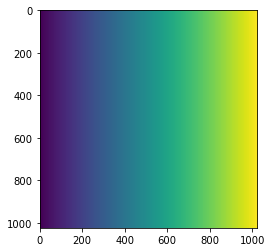

In [3]:
# Understanding Numba Code

import numpy
from numba import cuda

def escape_time(p, maxtime):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.
    """
    z = 0j
    for i in range(maxtime):
        z = z ** 2 + p
        if abs(z) > 2:
            return i
    return maxtime

escape_time_gpu = cuda.jit(device=True)(escape_time)

@cuda.jit
def mandelbrot_gpu(M, real_min, real_max, imag_min, imag_max):
    """Calculate the Mandelbrot set on the GPU.
    
    Parameters
    ----------
    M : numpy.ndarray
        a two-dimensional integer array that will contain the 
        escape times for each point.
    real_min: float
        minimum value on the real axis
    real_max: float
        maximum value on the real axis
    imag_min: float
        minimum value on the imaginary axis
    imag_max: float
        maximum value on the imaginary axis
    """
    ny, nx = M.shape
    i, j = cuda.grid(2)
    
    if i < ny and j < nx:
        dx = (real_max - real_min) / nx
        dy = (imag_max - imag_min) / ny
        p = real_min + dx * i + (imag_min + dy * j) * 1j
        M[i, j] = j#escape_time_gpu(p, 20)
        
        
M = numpy.zeros((1024, 1024), dtype=numpy.int32)
block = (32, 32)
grid = (M.shape[0] // block[0] if M.shape[0] % block[0] == 0 
            else M.shape[0] // block[0] + 1,
        int(M.shape[0] // block[1] if M.shape[1] % block[1] == 0 
            else M.shape[1] // block[1] + 1))


mandelbrot_gpu[grid, block](M, -2.0, 2.0, -1.6, 1.6)

plt.imshow(M, interpolation="nearest")


In [717]:
# Predicted Value from Regression Model is

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

Y_array = d
X_array = a

ind_z = 43
ind_y = 1000
ind_x = 2200

tx = X_array[ind_z-2:ind_z+3, ind_y-2:ind_y+3, ind_x-2:ind_x+3]
ty = Y_array[ind_z,           ind_y, ind_x]

X_test = np.array([tx.flatten()])
print(X_test.shape)

tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

print('Predicted Value From Model is ', tp4)
print('Ground Truth Value is         ', ty)
print(X_array[ind_z,           ind_y, ind_x])

(1, 125)
(1, 25) (25, 1) (1,)
Predicted Value From Model is  [[0.02117195]]
Ground Truth Value is          0.021088189
0.0209226


In [718]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_result8_a_1.raw', dtype='float32')
e = np.reshape(e, [58, 1280, 3200])

In [722]:
print(e[27, 1152, 1315])
print(d[27, 1152, 1315])
print(d[27, 1152, 1315] - e[27, 1152, 1315])

0.039948188
0.04013158
0.00018339232


In [2]:
import numba
from numba import njit, prange
from numba import cuda

In [10]:
# Define the dimensions of the volume
IMGSIZx = 3200
IMGSIZy = 1280
IMGSIZz = 58

# Cuda Kernel to calculate mean of neighboring voxels for each voxel
@cuda.jit(debug=True)
def calculate_mean(outbuf, inbuf):
    # Calculate the index of the voxel being considered
    
    ind_x, ind_y, ind_z = cuda.grid(3)
    #ind_x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    #ind_y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    #ind_z = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
    
    if ind_x < 0 or  ind_y < 0 or  ind_z < 0:
        return
    
    if ind_x > IMGSIZx-1 or ind_y > IMGSIZy-1 or ind_z > IMGSIZz-1:
        return
    
    sum1    = 0.0
    counter = 0
    for ind_nr_z in range(ind_z-2, ind_z+3):
        for ind_nr_y in range(ind_y-2, ind_y+3):
            for ind_nr_x in range(ind_x-2, ind_x+3):
                if ind_nr_x<0 or ind_nr_y<0 or ind_nr_z<0:
                    continue
                
                if ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1):
                    continue
                
                sum1    = sum1 + inbuf[ind_nr_z, ind_nr_y, ind_nr_x]
                counter = counter+1
    
    outbuf[ind_z, ind_y, ind_x] = sum1/counter
    return


# Create random input matrix for which to calculate voxel wise mean
inbuf = np.random.rand(58, 1280, 3200)
# Create output matrix to store the output 
outbuf  = np.zeros((58, 1280, 3200), np.float32)



# Code to Launch the Cuda kernel in Numba
# 8*400 = 3200 = IMGSIZx
# 8*160 = 1280 = IMGSIZy
# 2*29  = 58   = IMGSIZz
THREADS_PER_BLOCK = (8, 8, 2)
BLOCKS_PER_GRID   = (400, 160, 29)
calculate_mean[BLOCKS_PER_GRID, THREADS_PER_BLOCK](outbuf, inbuf)
cuda.synchronize()



# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.5002435831882374 0.5002436


In [5]:
# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.4530233603179261 0.45302337


In [6]:
print(c_x, c_y, c_z)

84 542 22


In [7]:
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3].flatten())

In [8]:
print(result_manual)

0.4530233603179261
